## NBA Champion Predictor
Project to analyze past nba playoff teams and championship winners to try to predict next seasons NBA champion

The first part will focus on analyzing the data and creating a learner to predict champions based on dataset of previous champions. The dataset of team records being used was found on [Kaggle](https://www.kaggle.com/boonpalipatana/nba-season-records-from-every-year#Team_Records.csv)

All other datasets used (rosters and player stats) were scraped from https://www.basketball-reference.com and the code necessary to obtain the data is in this [Github repo](https://github.com/kmaune/nba-champion-predictor/)

The second part will use next seasons nba rosters and try to project all the necessary statistics needed for the trained learner to predict who will win the championship next year. 

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib


pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 25)

historical_data = pd.read_csv('data/Team_Records.csv')
historical_data.head()

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,NaN,B. Stevens (29-10),K. Irving (5.7)
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5)
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7)
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5)
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,NaN,B. Stevens (25-57),B. Bass (5.1)


In [2]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 17 columns):
Season      1483 non-null object
Lg          1483 non-null object
Team        1483 non-null object
W           1483 non-null int64
L           1483 non-null int64
W/L%        1483 non-null float64
Finish      1483 non-null int64
SRS         1483 non-null float64
Pace        1463 non-null float64
Rel_Pace    1463 non-null float64
ORtg        1463 non-null float64
Rel_ORtg    1463 non-null float64
DRtg        1463 non-null float64
Rel_DRtg    1463 non-null float64
Playoffs    860 non-null object
Coaches     1483 non-null object
Top WS      1483 non-null object
dtypes: float64(8), int64(3), object(6)
memory usage: 197.0+ KB


Below function is used to see which, if any, columns have missing data. The function was found on [Stack Overflow](https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251)

In [3]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [4]:
missing_values_table(historical_data)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Playoffs,623,42.0
Pace,20,1.3
Rel_Pace,20,1.3
ORtg,20,1.3
Rel_ORtg,20,1.3
DRtg,20,1.3
Rel_DRtg,20,1.3


As can be seen from the dataset there are a lot of missing values for the playoffs columns. This is because there are no values in this column for teams who didn't make the playoffs. This isn't much of an issue and can be fixed easily.

The other missing values could use some further investigation to determine the possible impact and if needed possible solutions. But first I will fill in missing playoff values and create a new variable to give a 'reward' to a team based on their season result.

I want to assign a score for team playoff results. Rewards will be -1 for missing the playoffs, 0 for making the playoffs and +1 for winning the championship. 

NOTE: I may also want to look into different reward values that give some positive reward for how far a team advanced in the playoffs (e.g. 0 making first round, +.2 making second round,...,+1 making finals, +2 winning finals) but I will not investigate this further now. 

Currently I want to create a 'Season Value' column that correctly maps the simple rewards mentioned above to each teams season

In [5]:
season_result = pd.DataFrame(index=historical_data.index, columns=['Season Value'])

for season, team_info in historical_data.iterrows():
    if(team_info['Playoffs'] == 'Won Finals'):
        season_result.loc[season, 'Season Value'] = 1
    elif(pd.isna(team_info['Playoffs']) == False):
        season_result.loc[season, 'Season Value'] = 0
    elif(pd.isna(team_info['Playoffs']) == True):
        historical_data.loc[season, 'Playoffs'] = 'Missed Playoffs'
        season_result.loc[season, 'Season Value'] = -1

##season_result.head(15)

I also want to convert the Top WS column into a numeric column that has just the value of the Top WS, not the player information as well,

In [6]:
top_winshare = pd.DataFrame(index=historical_data.index, columns=['Top WS Value'])
for season, team_info in historical_data.iterrows():
    s = team_info['Top WS']
    s = s[s.find("(")+1:s.find(")")]
    top_winshare.loc[season, 'Top WS Value'] = s
top_winshare['Top WS Value'] = pd.to_numeric(top_winshare['Top WS Value'], errors='coerce')
top_winshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 1 columns):
Top WS Value    1483 non-null float64
dtypes: float64(1)
memory usage: 11.7 KB


In [7]:
##Concatonate new season value data to the original dataframe
historical_data = pd.concat([historical_data, top_winshare], axis=1)
historical_data = pd.concat([historical_data, season_result], axis=1)
historical_data.head()

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,Missed Playoffs,B. Stevens (29-10),K. Irving (5.7),5.7,-1
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5),12.5,0
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7),9.7,0
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5),6.5,0
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,Missed Playoffs,B. Stevens (25-57),B. Bass (5.1),5.1,-1


In [8]:
missing_values_table(historical_data)

Your selected dataframe has 19 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Pace,20,1.3
Rel_Pace,20,1.3
ORtg,20,1.3
Rel_ORtg,20,1.3
DRtg,20,1.3
Rel_DRtg,20,1.3


As we can see we have addressed the issue of missing values in the playoffs column, now lets further investigate the remaining missing values

In [9]:
null_data = historical_data[historical_data.isnull().any(axis=1)]
null_data.head(20)

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value
68,1949-50,NBA,Boston Celtics,22,46,0.324,6,-1.73,NaN,NaN,NaN,NaN,NaN,NaN,Missed Playoffs,A. Julian (22-46),B. Kinney (4.8),4.8,-1
69,1948-49,BAA,Boston Celtics,25,35,0.417,5,-2.76,NaN,NaN,NaN,NaN,NaN,NaN,Missed Playoffs,A. Julian (25-35),J. Seminoff (5.4),5.4,-1
70,1947-48,BAA,Boston Celtics*,20,28,0.417,3,-3.76,NaN,NaN,NaN,NaN,NaN,NaN,Lost Quarterfinals,J. Russell (20-28),E. Sadowski (9.3),9.3,0
71,1946-47,BAA,Boston Celtics,22,38,0.367,5,-4.45,NaN,NaN,NaN,NaN,NaN,NaN,Missed Playoffs,J. Russell (22-38),C. Simmons (6.1),6.1,-1
163,1949-50,NBA,New York Knicks*,40,28,0.588,2,2.53,NaN,NaN,NaN,NaN,NaN,NaN,Lost E. Div. Finals,J. Lapchick (40-28),H. Gallatin (7.8),7.8,0
164,1948-49,BAA,New York Knicks*,32,28,0.533,2,1.24,NaN,NaN,NaN,NaN,NaN,NaN,Lost E. Div. Finals,J. Lapchick (32-28),B. Palmer (7.2),7.2,0
165,1947-48,BAA,New York Knicks*,26,22,0.542,2,2.30,NaN,NaN,NaN,NaN,NaN,NaN,Lost Quarterfinals,J. Lapchick (26-22),B. Palmer (7.4),7.4,0
166,1946-47,BAA,New York Knicks*,33,27,0.550,3,0.58,NaN,NaN,NaN,NaN,NaN,NaN,Lost Semis,N. Cohalan (33-27),O. Schectman (4.3),4.3,0
235,1949-50,NBA,Syracuse Nationals*,51,13,0.797,1,6.48,NaN,NaN,NaN,NaN,NaN,NaN,Lost Finals,A. Cervi (51-13),D. Schayes (12.8),12.8,0
626,1949-50,NBA,Fort Wayne Pistons*,40,28,0.588,3,1.84,NaN,NaN,NaN,NaN,NaN,NaN,Lost Central Div. Finals,M. Mendenhall (40-28),F. Schaus (8.4),8.4,0


It appears that all of these missing columns are from very early NBA seasons, and it could be the case that the information needed to calculate the missing stats was not available.

At this point we can either leave these seasons in and leverage the information they have, or take them out. I am choosing to remove these seasons as they are missing almost all of the numerical stats we would use in our analysis and some of these seasons are pre-NBA. 

In [10]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 19 columns):
Season          1483 non-null object
Lg              1483 non-null object
Team            1483 non-null object
W               1483 non-null int64
L               1483 non-null int64
W/L%            1483 non-null float64
Finish          1483 non-null int64
SRS             1483 non-null float64
Pace            1463 non-null float64
Rel_Pace        1463 non-null float64
ORtg            1463 non-null float64
Rel_ORtg        1463 non-null float64
DRtg            1463 non-null float64
Rel_DRtg        1463 non-null float64
Playoffs        1483 non-null object
Coaches         1483 non-null object
Top WS          1483 non-null object
Top WS Value    1483 non-null float64
Season Value    1483 non-null int64
dtypes: float64(9), int64(4), object(6)
memory usage: 220.2+ KB


In [11]:
historical_data = historical_data[historical_data.notnull().all(axis=1)]
#historical_data.info()

In [12]:
missing_values_table(historical_data)

Your selected dataframe has 19 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


We now have no more missing values in our dataframe! Now we will do some exploratory data analysis to try to get a better understanding of our data

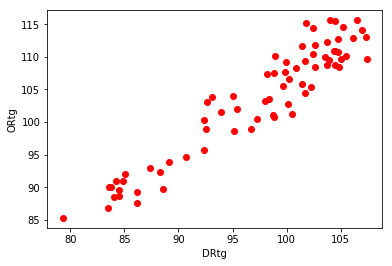

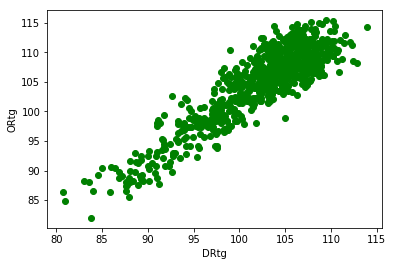

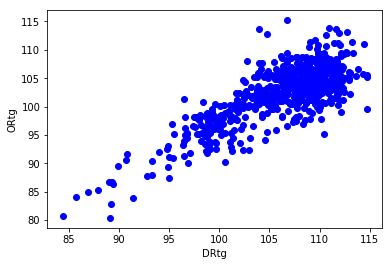

In [13]:
#Split our dataframe so we can analyze the data grouped together by season result
champion_data = historical_data.loc[historical_data['Season Value'] == 1]
playoff_data = historical_data.loc[historical_data['Season Value'] == 0]
lottery_data = historical_data.loc[historical_data['Season Value'] == -1]

plt.scatter(champion_data['DRtg'], champion_data['ORtg'], c='R')
plt.xlabel('DRtg')
plt.ylabel('ORtg')
plt.show()

plt.scatter(playoff_data['DRtg'], playoff_data['ORtg'], c='G')
plt.xlabel('DRtg')
plt.ylabel('ORtg')
plt.show()

plt.scatter(lottery_data['DRtg'], lottery_data['ORtg'], c='B')
plt.xlabel('DRtg')
plt.ylabel('ORtg')
plt.show()

Text(0,0.5,'ORtg')

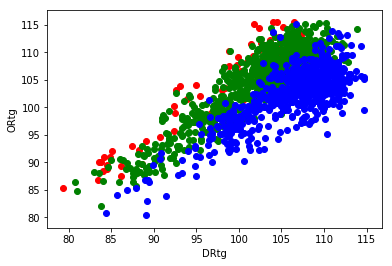

In [14]:
#Overlay of the above plots
plt.scatter(champion_data['DRtg'], champion_data['ORtg'], c='R')
plt.scatter(playoff_data['DRtg'], playoff_data['ORtg'], c='G')
plt.scatter(lottery_data['DRtg'], lottery_data['ORtg'], c='B')
plt.xlabel('DRtg')
plt.ylabel('ORtg')

As the above plots show, ORtg/DRtg could be a good indicator of whether or not a team makes the playoffs but doesn't necessarily seem to be a good indicator of a champion vs just making the playoffs. An issue though is that it appears the both ORtg and DRtg have increases linearly with time period, thus the magnitude of the numeric value isn't nearly as useful as the relative value compared to other teams in a given season. 

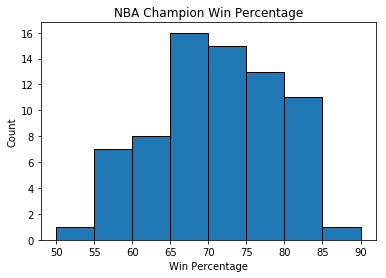

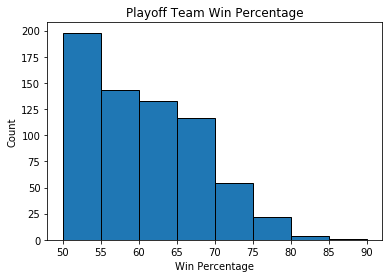

In [15]:
plt.hist(champion_data['W/L%']*100, bins=[50, 55, 60, 65, 70, 75, 80, 85, 90], edgecolor='black')
plt.xlabel('Win Percentage')
plt.ylabel('Count')
plt.title('NBA Champion Win Percentage')
plt.show()

plt.hist(playoff_data['W/L%']*100,  bins=[50, 55, 60, 65, 70, 75, 80, 85, 90], edgecolor='black')
plt.xlabel('Win Percentage')
plt.ylabel('Count')
plt.title('Playoff Team Win Percentage')
plt.show()

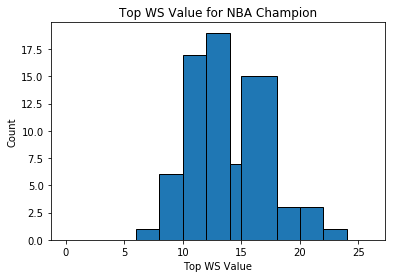

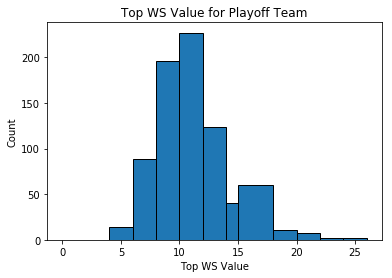

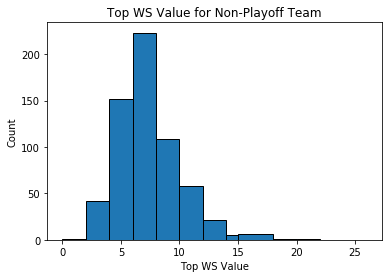

In [16]:
plt.hist(champion_data['Top WS Value'], edgecolor='black', bins=[0,2,4,6,8,10,12,14,15,18,20,22,24,26])
plt.xlabel('Top WS Value')
plt.ylabel('Count')
plt.title('Top WS Value for NBA Champion')
plt.show()

plt.hist(playoff_data['Top WS Value'], edgecolor='black', bins=[0,2,4,6,8,10,12,14,15,18,20,22,24,26])
plt.xlabel('Top WS Value')
plt.ylabel('Count')
plt.title('Top WS Value for Playoff Team')
plt.show()

plt.hist(lottery_data['Top WS Value'], edgecolor='black', bins=[0,2,4,6,8,10,12,14,15,18,20,22,24,26])
plt.xlabel('Top WS Value')
plt.ylabel('Count')
plt.title('Top WS Value for Non-Playoff Team')
plt.show()

The above data regarding WS shows a slight skew difference for lottery bound teams as opposed to playoff teams or champions but it is still not a clear cut indicator, especially between playoff teams and champions. 

This is actually slightly surprising as I would have assumed an even more clear cut distinction between the top WS values on the playoff vs non-playoff teams, as often in the NBA having one great player surrounded by solid role players could get you to the playoffs but it is very difficult for teams without a star player to make the playoffs or win championship.  

In [17]:
print(np.mean(champion_data['ORtg']))
print(np.mean(champion_data['DRtg']))
print(np.mean(champion_data['Pace']))
print(np.mean(champion_data['Top WS Value']))
print(np.mean(champion_data['Rel_ORtg']))
print(np.mean(champion_data['Rel_DRtg']))
print(np.mean(champion_data['Rel_Pace']))

103.42222222222225
97.25416666666665
103.47361111111115
13.645833333333336
2.258333333333334
-3.9055555555555554
1.9472222222222224


In [18]:
print(np.mean(playoff_data['ORtg']))
print(np.mean(playoff_data['DRtg']))
print(np.mean(playoff_data['Pace']))
print(np.mean(playoff_data['Top WS Value']))
print(np.mean(playoff_data['Rel_ORtg']))
print(np.mean(playoff_data['Rel_DRtg']))
print(np.mean(playoff_data['Rel_Pace']))

104.84002590673573
102.27305699481869
99.15272020725376
11.075518134715026
1.3239637305699474
-1.2410621761658018
0.3717616580310882


In [19]:
print(np.mean(lottery_data['ORtg']))
print(np.mean(lottery_data['DRtg']))
print(np.mean(lottery_data['Pace']))
print(np.mean(lottery_data['Top WS Value']))
print(np.mean(lottery_data['Rel_ORtg']))
print(np.mean(lottery_data['Rel_DRtg']))
print(np.mean(lottery_data['Rel_Pace']))

102.43586429725366
106.22213247172864
98.43909531502422
7.292730210016156
-1.854442649434571
1.9327948303715667
0.43489499192245584


(array([ 4., 20., 23.,  9.,  4.,  2.,  2.,  4.,  3.,  1.]),
 array([-5.1 , -2.92, -0.74,  1.44,  3.62,  5.8 ,  7.98, 10.16, 12.34,
        14.52, 16.7 ]),
 <a list of 10 Patch objects>)

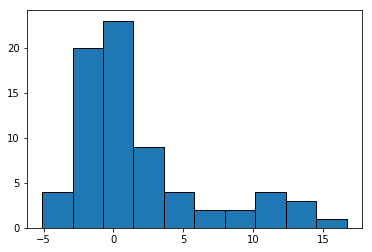

In [20]:
plt.hist(champion_data['Rel_Pace'], edgecolor='black')

(array([  4.,  29., 206., 252., 182.,  55.,  19.,  16.,   8.,   1.]),
 array([-9.5 , -6.86, -4.22, -1.58,  1.06,  3.7 ,  6.34,  8.98, 11.62,
        14.26, 16.9 ]),
 <a list of 10 Patch objects>)

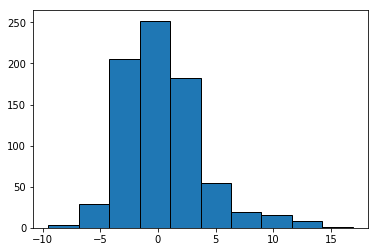

In [21]:
plt.hist(playoff_data['Rel_Pace'], edgecolor='black')

(array([ 13.,  93., 216., 216.,  64.,  12.,   2.,   0.,   1.,   2.]),
 array([-7.2 , -4.64, -2.08,  0.48,  3.04,  5.6 ,  8.16, 10.72, 13.28,
        15.84, 18.4 ]),
 <a list of 10 Patch objects>)

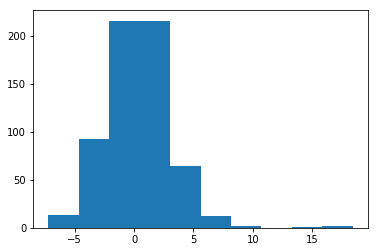

In [22]:
plt.hist(lottery_data['Rel_Pace'])

In [23]:
historical_data['NRtg'] = pd.Series((historical_data['ORtg'] - historical_data['DRtg']), index=historical_data.index)
historical_data.head(15)

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value,NRtg
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,Missed Playoffs,B. Stevens (29-10),K. Irving (5.7),5.7,-1,5.2
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5),12.5,0,2.8
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7),9.7,0,3.2
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5),6.5,0,0.2
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,Missed Playoffs,B. Stevens (25-57),B. Bass (5.1),5.1,-1,-4.8
5,2012-13,NBA,Boston Celtics*,41,40,0.506,3,-0.62,91.7,-0.3,103.1,-2.8,103.3,-2.6,Lost E. Conf. 1st Rnd.,D. Rivers (41-40),P. Pierce (7.2),7.2,0,-0.2
6,2011-12,NBA,Boston Celtics*,39,27,0.591,1,2.26,90.4,-0.9,101.0,-3.6,98.2,-6.4,Lost E. Conf. Finals,D. Rivers (39-27),P. Pierce (7.0),7.0,0,2.8
7,2010-11,NBA,Boston Celtics*,56,26,0.683,1,4.83,90.4,-1.7,106.2,-1.1,100.3,-7.0,Lost E. Conf. Semis,D. Rivers (56-26),P. Pierce (11.6),11.6,0,5.9
8,2009-10,NBA,Boston Celtics*,50,32,0.610,1,3.37,91.6,-1.1,107.7,0.1,103.8,-3.8,Lost Finals,D. Rivers (50-32),R. Rondo (9.6),9.6,0,3.9
9,2008-09,NBA,Boston Celtics*,62,20,0.756,1,7.44,90.4,-1.3,110.5,2.2,102.3,-6.0,Lost E. Conf. Semis,D. Rivers (62-20),R. Allen (11.1),11.1,0,8.2


In [24]:
def transform(x, max_x, min_x):
    transformed_x = 2 * ((x - min_x)/(max_x - min_x)) + 0.25
    return transformed_x

In [25]:
"""
Want to normalize the Pace variable so that all fall between [0.5,1.5] to use as a multiplier with the net rating.
This will allow teams Net Rating to be adjusted for pace of play, becoming larger in magnitude for fast paced teams, 
e.g. Norm_Pace > 1, and lower in magnitude for slower paced teams, e.g. Norm_Pace < 1
"""


historical_data['Norm_Pace'] = pd.Series(historical_data['Rel_Pace'], index=historical_data.index)

max_val = historical_data['Norm_Pace'].max()
min_val = historical_data['Norm_Pace'].min()

historical_data['Norm_Pace'] = historical_data['Norm_Pace'].apply(transform, max_x=max_val, min_x=min_val)


max_val = historical_data['Norm_Pace'].max()
min_val = historical_data['Norm_Pace'].min()

print(max_val)
print(min_val)

2.25
0.25


In [26]:
historical_data.head(20)

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value,NRtg,Norm_Pace
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,Missed Playoffs,B. Stevens (29-10),K. Irving (5.7),5.7,-1,5.2,0.809140
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5),12.5,0,2.8,0.959677
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7),9.7,0,3.2,1.124552
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5),6.5,0,0.2,1.067204
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,Missed Playoffs,B. Stevens (25-57),B. Bass (5.1),5.1,-1,-4.8,0.887993
5,2012-13,NBA,Boston Celtics*,41,40,0.506,3,-0.62,91.7,-0.3,103.1,-2.8,103.3,-2.6,Lost E. Conf. 1st Rnd.,D. Rivers (41-40),P. Pierce (7.2),7.2,0,-0.2,0.909498
6,2011-12,NBA,Boston Celtics*,39,27,0.591,1,2.26,90.4,-0.9,101.0,-3.6,98.2,-6.4,Lost E. Conf. Finals,D. Rivers (39-27),P. Pierce (7.0),7.0,0,2.8,0.866487
7,2010-11,NBA,Boston Celtics*,56,26,0.683,1,4.83,90.4,-1.7,106.2,-1.1,100.3,-7.0,Lost E. Conf. Semis,D. Rivers (56-26),P. Pierce (11.6),11.6,0,5.9,0.809140
8,2009-10,NBA,Boston Celtics*,50,32,0.610,1,3.37,91.6,-1.1,107.7,0.1,103.8,-3.8,Lost Finals,D. Rivers (50-32),R. Rondo (9.6),9.6,0,3.9,0.852151
9,2008-09,NBA,Boston Celtics*,62,20,0.756,1,7.44,90.4,-1.3,110.5,2.2,102.3,-6.0,Lost E. Conf. Semis,D. Rivers (62-20),R. Allen (11.1),11.1,0,8.2,0.837814


In [27]:
historical_data['Adjusted Margin'] = pd.Series((historical_data['ORtg'] - historical_data['DRtg']), index=historical_data.index)
historical_data['Adjusted Margin'] *= historical_data['Norm_Pace']
historical_data.head()

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,Missed Playoffs,B. Stevens (29-10),K. Irving (5.7),5.7,-1,5.2,0.809140,4.207527
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5),12.5,0,2.8,0.959677,2.687097
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7),9.7,0,3.2,1.124552,3.598566
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5),6.5,0,0.2,1.067204,0.213441
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,Missed Playoffs,B. Stevens (25-57),B. Bass (5.1),5.1,-1,-4.8,0.887993,-4.262366


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  4., 13., 22., 11., 10.,  8.]),
 array([-12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12]),
 <a list of 12 Patch objects>)

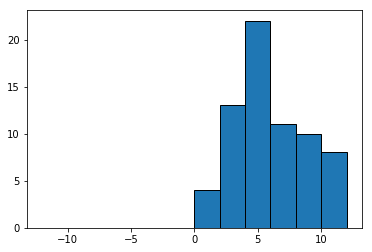

In [28]:
champion_data = historical_data.loc[historical_data['Season Value'] == 1]
playoff_data =  historical_data.loc[historical_data['Season Value'] == 0]
lottery_data =  historical_data.loc[historical_data['Season Value'] == -1]

plt.hist(champion_data['Adjusted Margin'], bins=[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12], edgecolor='black')

(array([  0.,   0.,   0.,   5.,  22., 124., 221., 204., 112.,  57.,  23.,
          3.]),
 array([-12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12]),
 <a list of 12 Patch objects>)

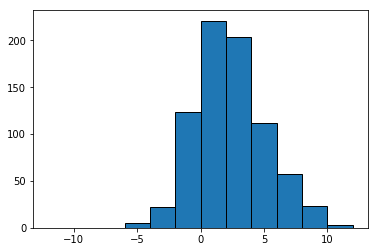

In [29]:
plt.hist(playoff_data['Adjusted Margin'], bins=[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12], edgecolor='black')

(array([ 17.,  37.,  89., 104., 165., 137.,  45.,  13.,   2.,   0.,   2.,
          1.]),
 array([-12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12]),
 <a list of 12 Patch objects>)

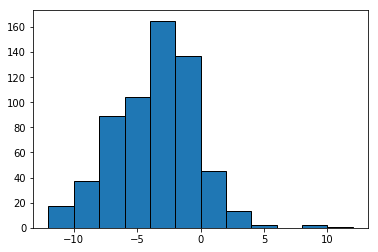

In [30]:
plt.hist(lottery_data['Adjusted Margin'], bins=[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12], edgecolor='black')

This new variable seems like it could be a good indicator of a teams success. As can be seen by the above plots, all instances of a team achieving over a +10 Adjusted Margin value resulted in a championship. Similarly no team with a negative Adjusted Margin has won a championship which makes intuitive sense. However it still appears it could be difficult to distinguish a championship team from a playoff team. 

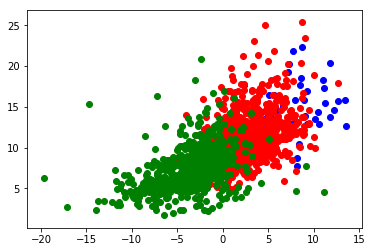

In [31]:
plt.scatter(champion_data['Adjusted Margin'], champion_data['Top WS Value'], color='B')
plt.scatter(playoff_data['Adjusted Margin'], playoff_data['Top WS Value'], color='R')
plt.scatter(lottery_data['Adjusted Margin'], lottery_data['Top WS Value'], color='G')

In [32]:
seasons = historical_data['Season'].unique()

last_season = historical_data.loc[historical_data['Season'] == seasons[2]]
last_season

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7),9.7,0,3.2,1.124552,3.598566
74,2015-16,NBA,Toronto Raptors*,56,26,0.683,1,4.08,92.9,-2.9,110.0,3.6,105.2,-1.2,Lost E. Conf. Finals,D. Casey (56-26),K. Lowry (11.6),11.6,0,4.8,0.723118,3.470968
97,2015-16,NBA,New York Knicks,32,50,0.390,3,-2.74,93.4,-2.4,104.6,-1.8,107.6,1.2,Missed Playoffs,D. Fisher (23-31) K. Rambis (9-19),C. Anthony (6.4),6.4,-1,-3.0,0.758961,-2.276882
169,2015-16,NBA,Philadelphia 76ers,10,72,0.122,5,-9.92,97.9,2.1,98.8,-7.6,109.2,2.8,Missed Playoffs,B. Brown (10-72),N. Noel (3.0),3.0,-1,-10.4,1.081541,-11.248029
238,2015-16,NBA,Brooklyn Nets,21,61,0.256,4,-7.12,95.2,-0.6,103.2,-3.2,110.9,4.5,Missed Playoffs,L. Hollins (10-27) T. Brown (11-34),B. Lopez (6.2),6.2,-1,-7.7,0.887993,-6.837545
289,2015-16,NBA,Minnesota Timberwolves,29,53,0.354,5,-3.38,95.2,-0.6,106.5,0.1,110.1,3.7,Missed Playoffs,S. Mitchell (29-53),K. Towns (8.3),8.3,-1,-3.6,0.887993,-3.196774
318,2015-16,NBA,Oklahoma City Thunder*,55,27,0.671,1,7.09,96.7,0.9,113.1,6.7,105.6,-0.8,Lost W. Conf. Finals,B. Donovan (55-27),K. Durant (14.5),14.5,0,7.5,0.995520,7.466398
369,2015-16,NBA,Denver Nuggets,33,49,0.402,4,-2.81,95.7,-0.1,105.6,-0.8,108.9,2.5,Missed Playoffs,M. Malone (33-49),N. Jokic (6.7),6.7,-1,-3.3,0.923835,-3.048656
420,2015-16,NBA,Portland Trail Blazers*,44,38,0.537,2,0.98,96.0,0.2,108.8,2.4,108.0,1.6,Lost W. Conf. Semis,T. Stotts (44-38),D. Lillard (9.2),9.2,0,0.8,0.945341,0.756272
468,2015-16,NBA,Utah Jazz,40,42,0.488,3,1.84,91.0,-4.8,105.9,-0.5,103.9,-2.5,Missed Playoffs,Q. Snyder (40-42),G. Hayward (8.9),8.9,-1,2.0,0.586918,1.173835


,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
318,2015-16,NBA,Oklahoma City Thunder*,55,27,0.671,1,7.09,96.7,0.9,113.1,6.7,105.6,-0.8,Lost W. Conf. Finals,B. Donovan (55-27),K. Durant (14.5),14.5,0,7.5,0.995520,7.466398
783,2015-16,NBA,Golden State Warriors*,73,9,0.890,1,10.38,99.3,3.5,114.5,8.1,103.8,-2.6,Lost Finals,S. Kerr (73-9),S. Curry (17.9),17.9,0,10.7,1.181900,12.646326
1357,2015-16,NBA,San Antonio Spurs*,67,15,0.817,1,10.28,93.8,-2.0,110.3,3.9,99.0,-7.4,Lost W. Conf. Semis,G. Popovich (67-15),K. Leonard (13.7),13.7,0,11.3,0.787634,8.900269


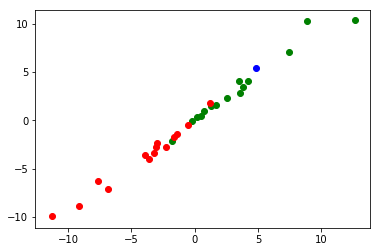

In [33]:
champion = last_season.loc[last_season['Season Value'] == 1]
playoff_data = last_season.loc[last_season['Season Value'] == 0]
lottery_data = last_season.loc[last_season['Season Value'] == -1]

plt.scatter(champion['Adjusted Margin'], champion['SRS'], color='B')
plt.scatter(playoff_data['Adjusted Margin'], playoff_data['SRS'], color='G')
plt.scatter(lottery_data['Adjusted Margin'], lottery_data['SRS'], color='R')

t = playoff_data.loc[playoff_data['Adjusted Margin'] > 5.0]
t

In [34]:
data_correlation = historical_data.corr()['Season Value'].sort_values()
data_correlation.head(15)

Finish            -0.715956
L                 -0.694293
Rel_DRtg          -0.596129
DRtg              -0.394067
Norm_Pace          0.047795
Rel_Pace           0.047795
Pace               0.088753
ORtg               0.153118
Rel_ORtg           0.500398
Top WS Value       0.572578
Adjusted Margin    0.724446
SRS                0.728301
NRtg               0.733598
W                  0.759362
W/L%               0.767332
Name: Season Value, dtype: float64

In [35]:
##Convert int64 dtypes to float
int_columns = list(historical_data.select_dtypes(include=['int64']).columns)
for col in int_columns:
    historical_data[col] = historical_data[col].astype(float)

historical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1482
Data columns (total 22 columns):
Season             1463 non-null object
Lg                 1463 non-null object
Team               1463 non-null object
W                  1463 non-null float64
L                  1463 non-null float64
W/L%               1463 non-null float64
Finish             1463 non-null float64
SRS                1463 non-null float64
Pace               1463 non-null float64
Rel_Pace           1463 non-null float64
ORtg               1463 non-null float64
Rel_ORtg           1463 non-null float64
DRtg               1463 non-null float64
Rel_DRtg           1463 non-null float64
Playoffs           1463 non-null object
Coaches            1463 non-null object
Top WS             1463 non-null object
Top WS Value       1463 non-null float64
Season Value       1463 non-null float64
NRtg               1463 non-null float64
Norm_Pace          1463 non-null float64
Adjusted Margin    1463 non-null float

In [36]:
y = historical_data['Season Value']
X = historical_data.drop('Season Value', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1482
Data columns (total 21 columns):
Season             1463 non-null object
Lg                 1463 non-null object
Team               1463 non-null object
W                  1463 non-null float64
L                  1463 non-null float64
W/L%               1463 non-null float64
Finish             1463 non-null float64
SRS                1463 non-null float64
Pace               1463 non-null float64
Rel_Pace           1463 non-null float64
ORtg               1463 non-null float64
Rel_ORtg           1463 non-null float64
DRtg               1463 non-null float64
Rel_DRtg           1463 non-null float64
Playoffs           1463 non-null object
Coaches            1463 non-null object
Top WS             1463 non-null object
Top WS Value       1463 non-null float64
NRtg               1463 non-null float64
Norm_Pace          1463 non-null float64
Adjusted Margin    1463 non-null float64
dtypes: float64(15), object(6)
memory 

I also want to now drop some of the categorical values, like league since it isn't useful, Top WS since it was already converted to a numerical value and playoffs since it was also already converted to the output result 'Season Value'. 

Others like Coaches, could likely be useful as a better coach certainly helps a teams chance at winning the championship. However, I have not come up with a consistent method of mapping coahces to numerical values representing their 'Coaching Score' and thus will drop it so it can be ignored. 

Season value I could also see potentially being useful as many league averages for things like ORtg,  DRtg and Pace change during different time periods. We already have relative features for each of these, and additional relative features like Adjusted Margin, and SRS. Because of this we will drop the Season feature as well.


Team I will also drop as the 'team name' that these statistics map to during a given season shouldn't make a difference on the outcome/prediction. That being said, some teams are historically more succesful than others and thus it is possible that the pedigree of an organization could have some impact and be useful to try to encode into numerical features. This is something possible for exploration at a later time. 

In [37]:
X.drop(['Lg', 'Season', 'Playoffs', 'Coaches', 'Top WS', 'Team'], axis=1, inplace=True)
X

,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,NRtg,Norm_Pace,Adjusted Margin
0,29.0,10.0,0.744,1.0,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,5.7,5.2,0.809140,4.207527
1,53.0,29.0,0.646,1.0,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,12.5,2.8,0.959677,2.687097
2,48.0,34.0,0.585,2.0,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,9.7,3.2,1.124552,3.598566
3,40.0,42.0,0.488,2.0,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,6.5,0.2,1.067204,0.213441
4,25.0,57.0,0.305,4.0,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,5.1,-4.8,0.887993,-4.262366
5,41.0,40.0,0.506,3.0,-0.62,91.7,-0.3,103.1,-2.8,103.3,-2.6,7.2,-0.2,0.909498,-0.181900
6,39.0,27.0,0.591,1.0,2.26,90.4,-0.9,101.0,-3.6,98.2,-6.4,7.0,2.8,0.866487,2.426165
7,56.0,26.0,0.683,1.0,4.83,90.4,-1.7,106.2,-1.1,100.3,-7.0,11.6,5.9,0.809140,4.773925
8,50.0,32.0,0.610,1.0,3.37,91.6,-1.1,107.7,0.1,103.8,-3.8,9.6,3.9,0.852151,3.323387
9,62.0,20.0,0.756,1.0,7.44,90.4,-1.3,110.5,2.2,102.3,-6.0,11.1,8.2,0.837814,6.870072


For now, I will just split the data into a training and testing set. However, I would like to come back and utilize some cross-validation to hopefully improve performace. 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_train.info(), X_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 902 to 190
Data columns (total 15 columns):
W                  1170 non-null float64
L                  1170 non-null float64
W/L%               1170 non-null float64
Finish             1170 non-null float64
SRS                1170 non-null float64
Pace               1170 non-null float64
Rel_Pace           1170 non-null float64
ORtg               1170 non-null float64
Rel_ORtg           1170 non-null float64
DRtg               1170 non-null float64
Rel_DRtg           1170 non-null float64
Top WS Value       1170 non-null float64
NRtg               1170 non-null float64
Norm_Pace          1170 non-null float64
Adjusted Margin    1170 non-null float64
dtypes: float64(15)
memory usage: 146.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 280 to 334
Data columns (total 15 columns):
W                  293 non-null float64
L                  293 non-null float64
W/L%               293 non-null float64
Finish 

(None, None)

In [39]:
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor(n_estimators=150))
hyperparameters = {'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [None, 5, 3, 1]}

clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.7112714947883578
0.09529328782707623


As we can see the learner achieved an R^2 score of ~.72 and a MSE of ~9.2%. The R^2 score measures how close the data is to the fitted regression line, and the best possible score is 1.0. It shows how much of the total variation in the data is explained by the model, or simply R^2 = Explained variation / Total variation. As such a score of ~.72 seems to be a score that is good enough for me to be confident in the models predicitve abilities. MSE assesses the quality of a predictor/estimator, and in my opinion based on past projects this value for MSE is certainly sufficient, though it is better to compare MSE between models to make this determination which I may try to come back and do later. 

For now though, I will accept this model as sufficient for predicting next years NBA champion and move on. 

For this next part, I need to try to generate accurately the necessary statistics for next years NBA teams so that I can then feed them into the learner and get my predicted NBA champion!. To help with this I scraped all teams current rosters for next season (on 7/23/19) and also every players stats for the previous 3 seasons. 


The first statistics I will attempt to generate are Wins and Losses for each team. In order to do this, I will utilize the Wins Above Replacement (WAR). WAR is a way to represent a players total contribution to their team, and how much value they add over a replacement level player. 

In the post, [The Relationship Between WAR and Team Wins](https://www.sports-reference.com/blog/2012/08/the-relationship-between-war-and-team-wins/), it is estimated that in baseball a team full of replacement level players would win 52 games, which is ~32% of games (52/162). This Win% is actually very close to the average of the Win % of the last place finishing team in the MLB for the last 5 years which I calculated to be 34.66%. The average Win% of the NBA last place team over the last 5 years have been a much lower 21.46%. Because of this, my baseline for total wins by a replacement level team will be 17.59 (0.2146 * 82).

To go from the baseline to the projected wins I will then add up all of the WAR for the players on a team and add that value to the baseline.

To check if this is reasonable I will see how well it predicts last years records for the Knicks, Lakers, Hawks, Bucks and Warrriors.

In [40]:
BASELINE_WINS = 17.59
advanced_stats = pd.read_csv('data/player_stats/2018-2019_advanced.csv')

advanced_stats.head()

,Player,Team,GP,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Álex Abrines,OKC,31,588,6.3,0.507,0.809,0.083,0.9,7.8,4.2,4.3,1.3,0.9,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2
1,Quincy Acy,PHO,10,123,2.9,0.379,0.833,0.556,2.7,20.1,11.3,8.2,0.4,2.7,15.2,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1
2,Jaylen Adams,ATL,34,428,7.6,0.474,0.673,0.082,2.6,12.3,7.4,19.8,1.5,1.0,19.7,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3
3,Steven Adams,OKC,80,2669,18.5,0.591,0.002,0.361,14.7,14.8,14.7,6.6,2.0,2.4,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2
4,Bam Adebayo,MIA,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4


In [41]:
hawks_advanced = advanced_stats.loc[advanced_stats['Team'] == 'ATL']
knicks_advanced = advanced_stats.loc[advanced_stats['Team'] == 'NYK']
bucks_advanced = advanced_stats.loc[advanced_stats['Team'] == 'MIL']
lakers_advanced = advanced_stats.loc[advanced_stats['Team'] == 'LAL']
gsw_advanced = advanced_stats.loc[advanced_stats['Team'] == 'GSW']

knicks_advanced

,Player,Team,GP,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
11,Kadeem Allen,NYK,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1
32,Ron Baker,NYK,11,107,4.4,0.376,0.563,0.375,1.0,6.0,3.4,16.1,2.3,0.0,13.9,8.6,0.0,0.0,0.0,0.002,-4.6,-1.4,-6.0,-0.1
95,Trey Burke,NYK,33,689,15.6,0.496,0.240,0.209,2.2,7.3,4.7,23.6,1.5,0.6,6.9,26.1,0.4,0.2,0.6,0.044,-0.2,-3.3,-3.5,-0.3
185,Damyean Dotson,NYK,73,2004,10.8,0.526,0.490,0.140,1.7,12.2,6.8,10.4,1.4,0.4,8.7,17.3,0.7,0.9,1.5,0.037,-0.9,-1.4,-2.3,-0.2
196,Henry Ellenson,NYK,17,234,12.9,0.536,0.400,0.271,2.2,23.8,12.7,10.0,1.4,0.7,8.6,19.0,0.1,0.2,0.3,0.070,-2.3,-1.4,-3.8,-0.1
232,Billy Garrett,NYK,4,63,9.8,0.452,0.296,0.148,0.0,5.1,2.5,18.0,0.8,1.3,6.5,20.9,0.0,0.0,0.0,-0.019,-4.0,-4.4,-8.4,-0.1
265,Tim Hardaway,NYK,46,1499,14.4,0.531,0.464,0.321,1.8,9.7,5.6,13.5,1.4,0.3,8.9,25.9,1.0,0.5,1.5,0.048,0.9,-3.0,-2.0,0.0
288,Mario Hezonja,NYK,58,1206,10.8,0.497,0.328,0.246,2.4,18.7,10.4,11.5,2.3,0.6,14.6,21.3,-1.1,1.1,-0.1,-0.003,-3.6,-0.4,-4.0,-0.6
289,Isaiah Hicks,NYK,3,32,17.4,0.588,0.000,0.625,6.4,16.7,11.4,9.4,1.5,7.9,8.9,15.0,0.1,0.0,0.1,0.153,-2.6,3.2,0.6,0.0
336,John Jenkins,NYK,22,319,9.3,0.518,0.544,0.175,1.9,10.1,5.9,9.9,0.0,0.5,7.5,16.1,0.2,0.0,0.2,0.024,-2.1,-3.5,-5.6,-0.3


In [42]:
hawks_advanced['WAR'] = hawks_advanced['VORP']*2.7
knicks_advanced['WAR'] = knicks_advanced['VORP']*2.7
bucks_advanced['WAR'] = bucks_advanced['VORP']*2.7
lakers_advanced['WAR'] = lakers_advanced['VORP']*2.7
gsw_advanced['WAR'] = gsw_advanced['VORP']*2.7

knicks_advanced.head()

,Player,Team,GP,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,WAR
11,Kadeem Allen,NYK,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1,0.27
32,Ron Baker,NYK,11,107,4.4,0.376,0.563,0.375,1.0,6.0,3.4,16.1,2.3,0.0,13.9,8.6,0.0,0.0,0.0,0.002,-4.6,-1.4,-6.0,-0.1,-0.27
95,Trey Burke,NYK,33,689,15.6,0.496,0.240,0.209,2.2,7.3,4.7,23.6,1.5,0.6,6.9,26.1,0.4,0.2,0.6,0.044,-0.2,-3.3,-3.5,-0.3,-0.81
185,Damyean Dotson,NYK,73,2004,10.8,0.526,0.490,0.140,1.7,12.2,6.8,10.4,1.4,0.4,8.7,17.3,0.7,0.9,1.5,0.037,-0.9,-1.4,-2.3,-0.2,-0.54
196,Henry Ellenson,NYK,17,234,12.9,0.536,0.400,0.271,2.2,23.8,12.7,10.0,1.4,0.7,8.6,19.0,0.1,0.2,0.3,0.070,-2.3,-1.4,-3.8,-0.1,-0.27


In [43]:
nyk_projected = BASELINE_WINS + knicks_advanced['WAR'].sum()
print("Knicks Projected:", nyk_projected)
print("Knicks Actual: 17")

Knicks Projected: 15.16
Knicks Actual: 17


In [44]:
hawks_projected = BASELINE_WINS + hawks_advanced['WAR'].sum()
print("Hawks Projected:", hawks_projected)
print("Hawks Actual: 29")

Hawks Projected: 25.42
Hawks Actual: 29


In [45]:
bucks_projected = BASELINE_WINS + bucks_advanced['WAR'].sum()
print("Bucks Projected:", bucks_projected)
print("Hawks Actual: 60")

Bucks Projected: 69.42999999999999
Hawks Actual: 60


In [46]:
lakers_projected = BASELINE_WINS + lakers_advanced['WAR'].sum()
print("Lakers Projected:", lakers_projected)
print("Lakers Actual: 37")

Lakers Projected: 40.54
Lakers Actual: 37


In [47]:
gsw_projected = BASELINE_WINS + gsw_advanced['WAR'].sum()
print("GSW Projected:", gsw_projected)
print("GSW Actual: 57")

GSW Projected: 65.11000000000001
GSW Actual: 57


As we can see, adding up the WAR of a team to the baseline total of ~17.5 wins results in pretty good estimations of the team wins. While not exact by any means it keeps the teams in the same 'tier' of wins they were actually in. For the better teams it appears to predict higher results than seen and I would assume this is partially because our WAR statistic is prorated over 82 games even, even if a player did not play 82 games. Weighting a players War by the percentage of games he played could improve this prediction. 

In [48]:
hawks_advanced['WAR'] = hawks_advanced['VORP']*2.7*(hawks_advanced['GP']/82)
knicks_advanced['WAR'] = knicks_advanced['VORP']*2.7*(knicks_advanced['GP']/82)
bucks_advanced['WAR'] = bucks_advanced['VORP']*2.7*(bucks_advanced['GP']/82)
lakers_advanced['WAR'] = lakers_advanced['VORP']*2.7*(lakers_advanced['GP']/82)
gsw_advanced['WAR'] = gsw_advanced['VORP']*2.7*(gsw_advanced['GP']/82)

hawks_projected = BASELINE_WINS + hawks_advanced['WAR'].sum()
nyk_projected = BASELINE_WINS + knicks_advanced['WAR'].sum()
bucks_projected = BASELINE_WINS + bucks_advanced['WAR'].sum()
lakers_projected = BASELINE_WINS + lakers_advanced['WAR'].sum()
gsw_projected = BASELINE_WINS + gsw_advanced['WAR'].sum()

print("Projections: ", hawks_projected, nyk_projected, bucks_projected, lakers_projected, gsw_projected)
print('Actuals: 29, 17, 60, 37, 57')


Projections:  25.42 15.838292682926829 63.667804878048784 34.92268292682927 58.07353658536586
Actuals: 29, 17, 60, 37, 57


This adjustment did make a slight improvement as all none of the teams win projections got further from the previous rounds and the win projections of the better teams is much closer than it was originally. As such, I think this method will now be sufficient for estimating the wins of a team next season. 

To determine what a players WAR will simply average their last 3 seasons WAR value. For players with 1-2 years experience I will be taking their previous year WAR + abs(0.1+ previous year WAR) to try to account for development. 

For Rookies, I will be calculaing the average WAR values for rookie seasons by draft position and assigning this to each rookie for their rookie year. 

While this is a simplistic method I want to note that just about every NBA champion I can remember in my lifetime (except maybe the 2011 Mavs or 2005 Pistons) had a Top-10 NBA player leading the way. NBA rookies often do not contribute much to a team early on and many that get the opportunity to are doing so on bad teams that have no realistic shot to win an NBA title. In that sense it may make more sense to just leave out Rookies with regards to WAR calculations since any team who gets a significant amount of their total WAR from rookies likely isnt a contender for the championship anyway. 

Similarly for developing players, though many likely see WAR increases of greater than the 10% I am giving them, I also do not recall any instances of players going from low WAR (i.e. average or worse play) to becoming a top player and leading a team to a championship. This is a much stronger assumption than the rookie assumption and will certainly add some bias to the projections. 

**Note:**
Some players names are different in the roster datasets vs the statistics datasets. Mostly these are instances of players with suffixes to their names (e.g. Jr, III) or players on two-way contracts who had (TW) next to their names on the datasets. When investigating this I found 26 instances where the names did not correctly match up, and I chose to just manually make the changes in the rosters datasets.

For some seasons, there was also an issue of foreign names having accent marks, or language specific letters in their names. I also manually changed these, this time in the statistics datasets since it was again only a few instances. 

In [49]:
seasons = ['2018-2019', '2017-2018', '2016-2017']
teams = ['ATL', 'BOS', 'BRK', 'CHO', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 
'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']


all_dict = {}
projections_dict = {}
all_nba_rosters = pd.read_csv("data/rosters/nba.csv")

for season in seasons:
    filepath =  'data/player_stats/{season}_advanced.csv'.format(season=season)
    stats = pd.read_csv(filepath)
    all_dict[season] = {}
    for team in teams:
        roster = all_nba_rosters.loc[all_nba_rosters['Team'] == team]
        all_dict[season][team] = roster.merge(stats, how='left', on=['Player'])
        temp = all_dict[season][team]
        temp = temp.drop(temp[temp.duplicated(subset=['Player'], keep='first')].index)
        all_dict[season][team] = temp
        temp2 = pd.DataFrame(index = temp.index, columns=temp.columns)
        temp2['Team_x'] = temp.Team_x
        temp2['Team_y'] = temp.Team_y
        temp2['Player'] = temp.Player
        temp2['Position'] = temp.Position
        temp2['Experience'] = temp.Experience
        temp2.loc[:, 'GP':] = 0.0
        projections_dict[team] = temp2

nyk = all_dict['2018-2019']['NYK']
nyk

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,NYK,Frank Ntilikina,G,2,NYK,43.0,904.0,6.0,0.417,0.408,0.106,1.4,...,1.6,1.3,15.9,16.6,-1.3,0.4,-0.8,-0.045,-4.5,-1.2,-5.7,-0.8
1,NYK,Dennis Smith,G,2,TOT,53.0,1508.0,12.3,0.502,0.320,0.240,2.2,...,2.1,1.1,17.6,24.8,-1.2,1.2,0.0,0.001,-1.7,-0.9,-2.5,-0.2
4,NYK,Damyean Dotson,G,2,NYK,73.0,2004.0,10.8,0.526,0.490,0.140,1.7,...,1.4,0.4,8.7,17.3,0.7,0.9,1.5,0.037,-0.9,-1.4,-2.3,-0.2
5,NYK,Kevin Knox,F,1,NYK,75.0,2158.0,8.7,0.475,0.398,0.247,2.9,...,1.0,0.9,10.1,22.3,-2.2,0.9,-1.3,-0.030,-3.6,-2.4,-6.0,-2.2
6,NYK,Mitchell Robinson,C,1,NYK,66.0,1360.0,22.0,0.692,0.000,0.464,13.3,...,1.8,10.0,9.1,12.1,4.0,2.2,6.1,0.217,0.5,5.2,5.7,2.7
7,NYK,Allonzo Trier,G,1,NYK,64.0,1459.0,12.2,0.564,0.255,0.431,2.2,...,0.9,0.8,15.8,21.5,0.4,0.5,0.9,0.030,-2.2,-2.0,-4.2,-0.8
8,NYK,Kadeem Allen,G,2,NYK,19.0,416.0,16.2,0.574,0.255,0.383,2.0,...,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1
9,NYK,RJ Barrett,G-F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NYK,Ignas Brazdeikis,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NYK,Julius Randle,F-C,5,NOP,73.0,2232.0,21.0,0.600,0.179,0.447,7.6,...,1.1,1.6,13.8,27.8,4.2,1.9,6.1,0.131,1.8,-0.4,1.4,1.9


Now we have a data structure where we can access each teams current roster for the upcoming season, and access their stats for each of the last 3 seasons. As we can see in the above, we still have the issue of NaN values for Rookies and we will have it as well for first and second year players. As previously mentioned the solution will simply be to use projected stats for these three players anyway so these NaN values we will not worry about right now.

However, I want to find any NaN values in the table that are not due to a player being a rookie or player with less than 3 years experience and assess what to do in these instances. 

In [50]:
all_rosters_help =  pd.read_csv('data/rosters/nba.csv')
season_stats_help = pd.read_csv('data/player_stats/2018-2019_advanced.csv', )

merged_df = all_rosters_help.merge(season_stats_help, how='left', on=['Player'])
##Remove Rookies
merged_df = merged_df.loc[(merged_df['Experience'] != 'R')]
##Get rows with null values
null_df = merged_df[pd.isnull(merged_df).any(axis=1)]
null_df

season_stats_help = pd.read_csv('data/player_stats/2017-2018_advanced.csv')
merged_df2 = all_rosters_help.merge(season_stats_help, how='left', on=['Player'])
##Remove Rookies
merged_df2 = merged_df2.loc[(merged_df2['Experience'] != 'R') & (merged_df2['Experience'] != '1')]
##Get rows with null values
null_df2 = merged_df2[pd.isnull(merged_df2).any(axis=1)]
null_df2

season_stats_help = pd.read_csv('data/player_stats/2016-2017_advanced.csv')
merged_df3 = all_rosters_help.merge(season_stats_help, how='left', on=['Player'])
##Remove Rookies
merged_df3 = merged_df3.loc[(merged_df3['Experience'] != 'R') & (merged_df3['Experience'] != '1') & (merged_df3['Experience'] != '2')]
##Get rows with null values
null_df3 = merged_df3[pd.isnull(merged_df3).any(axis=1)]
null_df3

print(null_df['Player'])
print('---------------')
print(null_df2['Player'])
print('---------------')
print(null_df3['Player'])

null_df

66           Denzel Valentine
122        Kristaps Porziņģis
204               C.J. Wilcox
296    Thanasis Antetokounmpo
355            Andre Roberson
468           Dejounte Murray
Name: Player, dtype: object
---------------
73     Brandon Knight
99         Seth Curry
136    Christian Wood
173       C.J. Wilcox
407       Tyler Lydon
462      Jordan McRae
Name: Player, dtype: object
---------------
158    Danuel House
Name: Player, dtype: object


,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
66,CHI,Denzel Valentine,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,DAL,Kristaps Porziņģis,F-C,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,IND,C.J. Wilcox,G,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,MIL,Thanasis Antetokounmpo,F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,OKC,Andre Roberson,G-F,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,SAS,Dejounte Murray,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see there are only a few cases like this. In the case of C.J. Wilcox, he does not appear to actually be Indiana's roster or any NBA roster so I will drop him from all the tables. 

In the case of Tyler Lydon it appears that he only played in one game and did not take a shot, and it appears that this is the case for Danuel House as well. As such I will just populate all their statistics with 0 for these seasons. 

For Christian Wood, it appears he played in the G-League only during the 2017-2018 season and for Jordan McRae he appears to have played overseas. I will fill back their most recent season stats.

In the case of Thanasis Antetokounmpo, he has not played in the NBA since only appearing in 2 games for the Knicks in the 2015-2016 season so I fill populate his stats with all 0's as well.

For all the remaining players, if they had an injury last season I will fill forward their pre-injury stats to use in the average. 

If they had an injury two seasons ago, I will fill back their stats from this season as I feel their post-injury stats should hold more weight in the average than their pre-injury stats. 

In [51]:
##Remove C.J Wilcox
ind = all_dict['2018-2019']['IND']
ind.drop(ind.loc[ind['Player'] == 'C.J. Wilcox'].index, inplace=True)
ind = all_dict['2017-2018']['IND']
ind.drop(ind.loc[ind['Player'] == 'C.J. Wilcox'].index, inplace=True)
ind = all_dict['2016-2017']['IND']
ind.drop(ind.loc[ind['Player'] == 'C.J. Wilcox'].index, inplace=True)
ind = projections_dict['IND']
ind.drop(ind.loc[ind['Player'] == 'C.J. Wilcox'].index, inplace=True)


ind

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,IND,Victor Oladipo,G,6,OKC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,IND,Domantas Sabonis,F-C,3,OKC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,IND,T.J. Leaf,F,2,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,IND,T.J. Warren,F,5,PHO,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,IND,Aaron Holiday,G,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
5,IND,Doug McDermott,F,5,TOT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
8,IND,Alize Johnson,F,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,IND,Myles Turner,C-F,4,IND,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
11,IND,Malcolm Brogdon,G,3,MIL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
12,IND,Goga Bitadze,C,R,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
## fill 0.0's for Danuel House, Tyler Lydon and Thanasis Antetokounmpo
sac = all_dict['2017-2018']['SAC']
hou = all_dict['2016-2017']['HOU']
mil = all_dict['2018-2019']['MIL']

sac.loc[sac['Player'] == 'Tyler Lydon', 'GP':] = 0
hou.loc[hou['Player'] == 'Danuel House', 'GP':] = 0
mil.loc[mil['Player'] == 'Thanasis Antetokounmpo', 'GP':] = 0

In [53]:
## Fill forward for last seasons injuries to Denzel Valentine, Kristaps Porzingis, Andre Roberson, Dejounte Murray

# Denzel Valentine
chi_2018 = all_dict['2018-2019']['CHI']
chi_2017 = all_dict['2017-2018']['CHI']
chi_2018.loc[chi_2018['Player']=='Denzel Valentine'] = chi_2017.loc[chi_2017['Player'] == 'Denzel Valentine'].values

# Andre Roberson
okc_2018 = all_dict['2018-2019']['OKC']
okc_2017 = all_dict['2017-2018']['OKC']
okc_2018.loc[okc_2018['Player']=='Andre Roberson'] = okc_2017.loc[okc_2017['Player'] == 'Andre Roberson'].values
okc_2018

#Dejounte Murray
sas_2018 = all_dict['2018-2019']['SAS']
sas_2017 = all_dict['2017-2018']['SAS']
sas_2018.loc[sas_2018['Player'] == 'Dejounte Murray'] = sas_2017.loc[sas_2017['Player'] == 'Dejounte Murray'].values
sas_2018

#Kristaps
dal_2018 = all_dict['2018-2019']['DAL']
dal_2017 = all_dict['2017-2018']['DAL']
dal_2018.loc[dal_2018['Player'] == 'Kristaps Porziņģis'] = dal_2017.loc[dal_2017['Player'] == 'Kristaps Porziņģis'].values
dal_2018

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,DAL,Dwight Powell,F-C,5,DAL,77.0,1662.0,20.4,0.682,0.261,0.523,9.1,...,1.3,2.6,10.1,17.2,5.6,1.9,7.5,0.215,2.8,1.2,4.0,2.5
1,DAL,Courtney Lee,G,11,TOT,34.0,428.0,10.3,0.492,0.426,0.163,2.2,...,2.4,0.6,9.2,15.3,0.1,0.4,0.4,0.050,-2.5,-0.2,-2.8,-0.1
4,DAL,Justin Jackson,G-F,2,TOT,81.0,1614.0,11.3,0.561,0.505,0.163,2.8,...,0.9,0.7,5.3,14.3,2.0,0.9,2.9,0.086,-0.4,-1.2,-1.6,0.2
7,DAL,Tim Hardaway,G,6,TOT,65.0,2057.0,13.6,0.527,0.480,0.278,1.7,...,1.3,0.3,8.6,25.4,1.0,0.9,1.8,0.043,0.5,-2.9,-2.4,-0.2
10,DAL,Luka Dončić,G-F,1,DAL,72.0,2318.0,19.6,0.545,0.433,0.409,4.0,...,1.6,0.9,15.0,30.5,2.1,2.8,4.9,0.101,2.9,1.2,4.1,3.6
11,DAL,Ryan Broekhoff,F,1,DAL,42.0,453.0,10.7,0.621,0.738,0.151,1.9,...,0.6,0.8,10.6,14.3,0.5,0.3,0.8,0.086,-0.7,-1.7,-2.3,0.0
12,DAL,Jalen Brunson,G,1,DAL,73.0,1591.0,12.8,0.549,0.320,0.212,1.7,...,1.1,0.2,12.5,19.1,1.5,1.0,2.6,0.077,-0.8,-1.6,-2.5,-0.2
13,DAL,Kostas Antetokounmpo,F,1,DAL,2.0,11.0,-0.9,0.210,0.000,1.333,0.0,...,8.8,0.0,17.4,22.5,-0.1,0.0,-0.1,-0.247,-15.9,2.7,-13.3,0.0
14,DAL,Daryl Macon,G,1,DAL,8.0,90.0,5.5,0.482,0.407,0.259,2.4,...,0.5,0.0,16.6,17.2,-0.1,0.0,0.0,-0.022,-5.1,-2.1,-7.2,-0.1
15,DAL,Delon Wright,G,4,TOT,75.0,1699.0,15.5,0.523,0.301,0.269,4.4,...,2.5,1.6,11.0,18.1,1.9,2.4,4.3,0.121,0.0,1.5,1.5,1.5


In [54]:
"""
Fill back stats injury 2 seasons ago for Brandon Knight, Seth Curry, 
Also fill back stats for Chrisitan Wood, Jordan McRae who played overseas/G-League
"""

# Brandon Knight
cle_2018 = all_dict['2018-2019']['CLE']
cle_2017 = all_dict['2017-2018']['CLE']
cle_2017.loc[cle_2017['Player'] == 'Brandon Knight'] = cle_2018.loc[cle_2018['Player'] == 'Brandon Knight']
cle_2017

#Seth Curry
dal_2018 = all_dict['2018-2019']['DAL']
dal_2017 = all_dict['2017-2018']['DAL']
dal_2017.loc[dal_2017['Player'] == 'Seth Curry'] = dal_2018.loc[dal_2018['Player'] == 'Seth Curry'].values

#Christian Wood
det_2018 = all_dict['2018-2019']['DET']
det_2017 = all_dict['2017-2018']['DET']
det_2017.loc[det_2017['Player'] == 'Christian Wood'] = det_2018.loc[det_2018['Player'] == 'Christian Wood'].values

#Jordan McRae
was_2018 = all_dict['2018-2019']['WAS']
was_2017 = all_dict['2017-2018']['WAS']
was_2017.loc[was_2017['Player'] == 'Jordan McRae'] = was_2018.loc[was_2018['Player'] == 'Jordan McRae'].values

was_2017

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,WAS,Ian Mahinmi,C,11,WAS,77.0,1145.0,12.2,0.601,0.008,0.516,13.4,...,1.6,3.2,24.7,15.6,0.8,1.4,2.2,0.093,-2.3,1.6,-0.7,0.4
1,WAS,Bradley Beal,G,7,WAS,82.0,2977.0,18.4,0.564,0.357,0.249,2.3,...,1.6,1.1,11.5,27.6,4.4,2.5,6.9,0.111,2.7,-1.0,1.7,2.7
2,WAS,C.J. Miles,G-F,14,TOR,70.0,1337.0,13.0,0.545,0.758,0.162,1.5,...,1.4,1.3,5.7,22.3,1.4,1.5,2.9,0.103,1.7,-2.2,-0.5,0.5
3,WAS,John Wall,G,9,WAS,41.0,1410.0,19.1,0.515,0.250,0.361,1.8,...,2.0,2.8,17.0,29.1,1.2,1.5,2.7,0.092,1.6,0.0,1.5,1.2
4,WAS,Moritz Wagner,F-C,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,WAS,Troy Brown,G-F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,WAS,Isaac Bonga,G,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,WAS,Dāvis Bertāns,F,3,SAS,77.0,1086.0,14.1,0.588,0.689,0.134,1.8,...,1.2,2.1,8.5,17.4,1.6,1.4,3.1,0.135,1.2,-0.3,1.0,0.8
8,WAS,Jemerrio Jones,F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,WAS,Jordan McRae,G,3,WAS,27.0,333.0,14.3,0.550,0.269,0.269,1.9,...,1.8,1.8,9.4,20.4,0.3,0.2,0.5,0.066,-1.9,-1.8,-3.7,-0.1


In [55]:
projections_dict['NYK']


,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,NYK,Frank Ntilikina,G,2,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,NYK,Dennis Smith,G,2,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,NYK,Damyean Dotson,G,2,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,NYK,Kevin Knox,F,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,NYK,Mitchell Robinson,C,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
5,NYK,Allonzo Trier,G,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
6,NYK,Kadeem Allen,G,2,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
7,NYK,RJ Barrett,G-F,R,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
8,NYK,Ignas Brazdeikis,F,R,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,NYK,Julius Randle,F-C,5,LAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


While I had previously stated I would average the last 3 years stats together in order to calculate next years projections, I have decided to weight things a little differently. Instead of giving all the years the same weight, I will weight the most recent year the highest, and the furthest year the least to hopefully get more accurate projections. 

In [56]:
#Populate cumulative totals for players with 3+ years experience 
weights = [0.5, 0.3, 0.2]
i = 0
for season in seasons:
    for team in teams:
        stats = all_dict[season][team]
        projection = projections_dict[team]
        projection.loc[:, 'GP':] = projection.loc[:, 'GP':].values + (stats.loc[:, 'GP':].values * weights[i])
    i += 1
nyk = projections_dict['NYK']
nyk

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,NYK,Frank Ntilikina,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NYK,Dennis Smith,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NYK,Damyean Dotson,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NYK,Kevin Knox,F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NYK,Mitchell Robinson,C,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NYK,Allonzo Trier,G,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NYK,Kadeem Allen,G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NYK,RJ Barrett,G-F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NYK,Ignas Brazdeikis,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NYK,Julius Randle,F-C,5,LAL,75.9,2199.4,19.73,0.5904,0.1209,0.4375,7.95,...,1.04,1.59,15.03,25.77,3.7,2.03,5.73,0.125,0.86,0.12,0.97,1.65


One thing I would like to account for as not doing so would have a large impact on my projections is that I know that KD will be out all season and thus do not want his projections making an impact on the Nets, so I will set all of his stats to 0. 

Also for Klay Thompson the most optimistic predictions have him out until at least the all star break, with many predicting he will be out all season. I will set his GP stat to 10 games so that he won't contribute much on WAR or any stats that factor in games played but I still have his other stats handy in case they are needed.

In [57]:
brk = projections_dict['BRK']
brk.loc[brk['Player'] == 'Kevin Durant', 'GP':] = 0.0

gsw = projections_dict['GSW']
gsw.loc[gsw['Player'] == 'Klay Thompson', 'GP'] = 10.0
gsw

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,GSW,Draymond Green,F,7,GSW,69.2,2212.8,14.58,0.5342,0.4007,0.2573,3.71,...,2.3,3.01,24.11,14.95,1.89,3.7,5.62,0.1201,-0.48,3.51,3.04,2.87
1,GSW,Stephen Curry,G,10,GSW,65.6,2182.4,25.58,0.6478,0.5854,0.2622,2.45,...,2.19,0.67,12.39,30.52,7.5,2.6,10.1,0.2254,8.38,-1.17,7.19,5.01
2,GSW,Jacob Evans,G-F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GSW,Alfonzo McKinnie,F,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GSW,Jordan Poole,G,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GSW,Alen Smailagić,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GSW,Eric Paschall,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GSW,D'Angelo Russell,G,4,LAL,67.5,1956.4,17.32,0.5228,0.4223,0.1694,2.29,...,1.83,0.74,14.96,30.51,1.11,1.77,2.88,0.0593,2.41,-0.93,1.48,1.94
8,GSW,Willie Cauley-Stein,F-C,4,SAC,77.4,2003.9,17.54,0.5533,0.0071,0.3303,7.6,...,1.95,2.49,10.04,19.23,2.69,2.41,5.1,0.1206,-0.89,1.77,0.88,1.57
9,GSW,Glenn Robinson,G-F,5,IND,44.2,691.8,9.89,0.527,0.37,0.1972,3.46,...,1.4,0.88,7.66,13.81,0.43,0.63,1.03,0.0704,-2.26,-0.71,-2.9,-0.11


Now I will fill in the projected stats for players with 1 and 2 years of experience. As previously mentioned I will use the formula of projected_stat = last_year_stat + abs(0.1 * last_year_stat). However I will need to check that no players GP is greater than 82. 

In [58]:
for team in teams:
    stats = all_dict['2018-2019'][team]
    projection = projections_dict[team]
    projection.loc[(projection['Experience'] == '1') | (projection['Experience'] == '2'), 'GP':] = stats.loc[(stats['Experience'] == '1') | (stats['Experience'] == '2'), 'GP':].values + abs(0.1 * stats.loc[(stats['Experience'] == '1') | (stats['Experience'] == '2'), 'GP':].values)
    projection.loc[projection['GP'] > 82.0, 'GP'] = 82.0
projections_dict['NYK']

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,NYK,Frank Ntilikina,G,2,NaN,47.3,994.4,6.6,0.4587,0.4488,0.1166,1.54,...,1.76,1.43,17.49,18.26,-1.17,0.44,-0.72,-0.0405,-4.05,-1.08,-5.13,-0.72
1,NYK,Dennis Smith,G,2,NaN,58.3,1658.8,13.53,0.5522,0.352,0.264,2.42,...,2.31,1.21,19.36,27.28,-1.08,1.32,0,0.0011,-1.53,-0.81,-2.25,-0.18
2,NYK,Damyean Dotson,G,2,NaN,80.3,2204.4,11.88,0.5786,0.539,0.154,1.87,...,1.54,0.44,9.57,19.03,0.77,0.99,1.65,0.0407,-0.81,-1.26,-2.07,-0.18
3,NYK,Kevin Knox,F,1,NaN,82,2373.8,9.57,0.5225,0.4378,0.2717,3.19,...,1.1,0.99,11.11,24.53,-1.98,0.99,-1.17,-0.027,-3.24,-2.16,-5.4,-1.98
4,NYK,Mitchell Robinson,C,1,NaN,72.6,1496,24.2,0.7612,0,0.5104,14.63,...,1.98,11,10.01,13.31,4.4,2.42,6.71,0.2387,0.55,5.72,6.27,2.97
5,NYK,Allonzo Trier,G,1,NaN,70.4,1604.9,13.42,0.6204,0.2805,0.4741,2.42,...,0.99,0.88,17.38,23.65,0.44,0.55,0.99,0.033,-1.98,-1.8,-3.78,-0.72
6,NYK,Kadeem Allen,G,2,NaN,20.9,457.6,17.82,0.6314,0.2805,0.4213,2.2,...,2.09,0.88,14.96,21.56,0.77,0.22,1.1,0.1221,0.55,-1.44,-0.99,0.11
7,NYK,RJ Barrett,G-F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NYK,Ignas Brazdeikis,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NYK,Julius Randle,F-C,5,LAL,75.9,2199.4,19.73,0.5904,0.1209,0.4375,7.95,...,1.04,1.59,15.03,25.77,3.7,2.03,5.73,0.125,0.86,0.12,0.97,1.65


Now all that is left is to populate the Rookie statistics. First I need to calculate the average value of the stats for each draft position.

For simplicity any player who didn't play their rookie season, or who never played in the NBA will have their rookie year stats set to all 0's and still factored into the calculation

First I will populate a dictionary that can be indexed by draft year, with that years draft picks and their rookie year stats

In [59]:
current_draft = pd.read_csv('data/drafts/2019_draft.csv')
years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']
drafts = {}

for year in years:
    draft = pd.read_csv('data/drafts/{draft_year}_draft.csv'.format(draft_year=year.split("-")[0]))
    stats = pd.read_csv('data/player_stats/{year}_advanced.csv'.format(year=year))
    ##Remove any players that didn't play in the nba that year
    combined = draft.merge(stats, how='left', on=['Player'])
    combined.fillna(0, inplace=True)
    combined.drop(combined[combined.duplicated(subset=['Player'], keep='first')].index, inplace=True)
    combined.loc[:, 'Team_y'] = combined.loc[:, 'Team_x'] #Don't really care which team they played for, just want to remove 0's from this column
    drafts[year.split("-")[0]] = combined

drafts['2012'].head()





,Pick Number,Team_x,Player,NBA Seasons,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,NOH,Anthony Davis,7.0,NOH,64.0,1846.0,21.7,0.559,0.009,0.333,10.5,...,2.2,5.1,10.3,21.8,3.7,2.4,6.1,0.159,0.5,1.9,2.3,2.0
1,2,CHA,Michael Kidd-Gilchrist,7.0,CHA,78.0,2025.0,14.0,0.506,0.015,0.305,7.2,...,1.4,2.8,12.7,17.9,1.1,1.0,2.1,0.051,-2.3,0.1,-2.2,-0.1
2,3,WAS,Bradley Beal,7.0,WAS,56.0,1745.0,13.6,0.515,0.344,0.231,2.7,...,1.5,1.3,10.6,22.2,1.0,2.0,3.0,0.082,0.0,0.0,-0.1,0.9
3,4,CLE,Dion Waiters,7.0,CLE,61.0,1756.0,13.7,0.492,0.249,0.261,1.4,...,1.7,0.7,11.8,26.1,0.3,0.6,0.9,0.026,-0.5,-2.7,-3.2,-0.5
4,5,SAC,Thomas Robinson,5.0,SAC,70.0,1056.0,10.9,0.451,0.003,0.340,13.0,...,2.0,1.9,19.3,19.1,-0.9,0.9,-0.1,-0.002,-4.4,-0.1,-4.5,-0.7


Next I will populate a dataframe that has the average rookie year stats of all players selected at that pick

In [60]:
pick_projections = pd.DataFrame(columns = drafts['2012'].columns)
pick_projections['Pick Number'] = drafts['2012']['Pick Number']
pick_projections.drop(['Team_x', 'Player', 'NBA Seasons', 'Team_y'], axis=1, inplace=True)
pick_projections.fillna(0.0, inplace=True)

weight = 1/(len(years)-1)

for year in years:
    draft = drafts[year.split("-")[0]]
    for pick in range(1, 61):
        pick_projections.loc[pick_projections['Pick Number'] == pick, 'GP':] = pick_projections.loc[pick_projections['Pick Number'] == pick, 'GP':].values + (draft.loc[draft['Pick Number'] == pick, 'GP':].values * weight)
    

pick_projections.head()    

,Pick Number,GP,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,60.833333,1756.833333,16.316667,0.519167,0.074333,0.282500,8.316667,19.683333,13.966667,12.016667,1.666667,2.600000,12.366667,22.316667,2.350000,1.333333,3.683333,0.081167,-1.350000,0.116667,-1.216667,0.866667
1,2,76.000000,2189.166667,15.866667,0.589000,0.272667,0.317333,6.083333,17.916667,11.916667,18.050000,2.133333,1.933333,17.316667,24.250000,-0.016667,1.716667,1.666667,0.053667,-1.766667,0.083333,-1.650000,0.250000
2,3,62.666667,1625.333333,13.650000,0.521000,0.270833,0.270333,4.733333,15.633333,10.166667,12.266667,1.350000,1.416667,12.333333,22.200000,1.033333,1.883333,2.950000,0.067667,-1.450000,-0.183333,-1.650000,0.733333
3,4,73.333333,1677.333333,14.900000,0.589333,0.309500,0.336833,6.483333,18.483333,12.400000,10.966667,1.716667,3.300000,15.450000,24.716667,0.166667,1.683333,1.866667,0.056000,-2.633333,-0.016667,-2.600000,0.000000
4,5,84.166667,1751.666667,11.600000,0.561167,0.317667,0.284333,5.916667,15.183333,10.466667,20.100000,1.866667,1.833333,22.616667,21.683333,-0.450000,1.066667,0.616667,0.016667,-3.216667,-0.883333,-4.116667,-0.483333


In [61]:

for team in teams:
    #Get rookies
    projection = projections_dict[team]
    rookies = projection.loc[projection['Experience'] == 'R']
    for index, row in rookies.iterrows():
        if row['Player'] in current_draft['Player'].values:
            pick = current_draft.loc[current_draft['Player'] == row['Player'], 'Pick Number'].values
            projection.loc[projection['Player'] == row['Player'], 'GP':] = pick_projections.loc[pick_projections['Pick Number'] == pick[0], 'GP':].values
        #Undrafted, fill with 0s
        else:
            projection.loc[projection['Player'] == row['Player'], 'GP':] = 0.0
    projection['WAR'] = projection['VORP']*2.7*(projection['GP']/82)
            
projections_dict['NYK'].head(15)

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,WAR
0,NYK,Frank Ntilikina,G,2,NaN,47.3,994.4,6.6,0.4587,0.4488,0.1166,1.54,...,1.43,17.49,18.26,-1.17,0.44,-0.72,-0.0405,-4.05,-1.08,-5.13,-0.72,-1.12136
1,NYK,Dennis Smith,G,2,NaN,58.3,1658.8,13.53,0.5522,0.352,0.264,2.42,...,1.21,19.36,27.28,-1.08,1.32,0,0.0011,-1.53,-0.81,-2.25,-0.18,-0.345534
2,NYK,Damyean Dotson,G,2,NaN,80.3,2204.4,11.88,0.5786,0.539,0.154,1.87,...,0.44,9.57,19.03,0.77,0.99,1.65,0.0407,-0.81,-1.26,-2.07,-0.18,-0.475924
3,NYK,Kevin Knox,F,1,NaN,82,2373.8,9.57,0.5225,0.4378,0.2717,3.19,...,0.99,11.11,24.53,-1.98,0.99,-1.17,-0.027,-3.24,-2.16,-5.4,-1.98,-5.346
4,NYK,Mitchell Robinson,C,1,NaN,72.6,1496,24.2,0.7612,0,0.5104,14.63,...,11,10.01,13.31,4.4,2.42,6.71,0.2387,0.55,5.72,6.27,2.97,7.09975
5,NYK,Allonzo Trier,G,1,NaN,70.4,1604.9,13.42,0.6204,0.2805,0.4741,2.42,...,0.88,17.38,23.65,0.44,0.55,0.99,0.033,-1.98,-1.8,-3.78,-0.72,-1.669
6,NYK,Kadeem Allen,G,2,NaN,20.9,457.6,17.82,0.6314,0.2805,0.4213,2.2,...,0.88,14.96,21.56,0.77,0.22,1.1,0.1221,0.55,-1.44,-0.99,0.11,0.0756988
7,NYK,RJ Barrett,G-F,R,NaN,62.6667,1625.33,13.65,0.521,0.270833,0.270333,4.73333,...,1.41667,12.3333,22.2,1.03333,1.88333,2.95,0.0676667,-1.45,-0.183333,-1.65,0.733333,1.51317
8,NYK,Ignas Brazdeikis,F,R,NaN,19.5,139.333,5.53333,0.360833,0.304667,0.2535,4.28333,...,1.68333,12.5167,18.75,-0.2,0.0833333,-0.116667,-0.0445,-5.06667,-2.3,-7.35,-0.166667,-0.107012
9,NYK,Julius Randle,F-C,5,LAL,75.9,2199.4,19.73,0.5904,0.1209,0.4375,7.95,...,1.59,15.03,25.77,3.7,2.03,5.73,0.125,0.86,0.12,0.97,1.65,4.12359


We now have all of our projected player stats to allow us to be able to begin to predict our team stats for the upcoming season. We will start by making our Team projection dataframe and predicting the Win-Loss Record of each team using the method previously discussed

In [62]:
team_projections = pd.DataFrame(columns=historical_data.columns)
team_projections.drop(['Lg', 'Season', 'Playoffs', 'Coaches', 'Top WS'], axis=1, inplace=True)

i = 0;
for team in teams:
    projection = projections_dict[team]
    team_projections.loc[i, 'Team'] = team
    team_projections.loc[i, 'W'] = BASELINE_WINS + projection['WAR'].sum() 
    team_projections.loc[i, 'L'] = 82 - team_projections.loc[i, 'W']
    team_projections.loc[i, 'W/L%'] = team_projections.loc[i, 'W']/82.0
    team_projections.loc[i, 'Finish'] = 1
    i+=1

team_projections

,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BOS,42.2594,39.7406,0.515359,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRK,47.5168,34.4832,0.579473,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHO,31.1577,50.8423,0.379972,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHI,34.9373,47.0627,0.426064,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CLE,15.6878,66.3122,0.191315,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DAL,45.0038,36.9962,0.548827,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DEN,57.3802,24.6198,0.699758,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,DET,36.7968,45.2032,0.448742,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GSW,45.1789,36.8211,0.550962,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
#Update Finish for each team
Atlantic_Division = ['BOS', 'BRK', 'NYK', 'PHI', 'TOR']
Central_Division = ['CHI', 'CLE', 'DET', 'IND', 'MIL']
Southeast_Division = ['ATL', 'CHO', 'MIA', 'ORL', 'WAS']
Northwest_Division = ['DEN', 'MIN', 'OKC', 'POR', 'UTA']
Pacific_Division =['GSW', 'LAC', 'LAL', 'PHO', 'SAC']
Southwest_Division =['DAL', 'HOU', 'MEM', 'NOP', 'SAS']


for team in Atlantic_Division:
    for j in range(0, 5):
        team2 = Atlantic_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1

for team in Central_Division:
    for j in range(0, 5):
        team2 = Central_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1

for team in Southeast_Division:
    for j in range(0, 5):
        team2 = Southeast_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1

for team in Northwest_Division:
    for j in range(0, 5):
        team2 = Northwest_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1

for team in Pacific_Division:
    for j in range(0, 5):
        team2 = Pacific_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1

            
for team in Southwest_Division:
    for j in range(0, 5):
        team2 = Southwest_Division[j]
        if team_projections.loc[team_projections['Team'] == team, 'W'].values[0] < team_projections.loc[team_projections['Team'] == team2, 'W'].values[0]:
            team_projections.loc[team_projections['Team']== team, 'Finish'] += 1
            
team_projections
        

,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BOS,42.2594,39.7406,0.515359,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRK,47.5168,34.4832,0.579473,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHO,31.1577,50.8423,0.379972,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHI,34.9373,47.0627,0.426064,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CLE,15.6878,66.3122,0.191315,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DAL,45.0038,36.9962,0.548827,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DEN,57.3802,24.6198,0.699758,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,DET,36.7968,45.2032,0.448742,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GSW,45.1789,36.8211,0.550962,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the Pace statistic I will use statistics on the pace of the team over the 2 most recent seasons in my dataset (2017-2018 and 2016-2017), giving higher weight to the most recent season. To try to account for the fact that pace of play in the NBA has been increasing league wide the last few seasons and I am not using the most recent season in my calculation I will also increase the pace I calculate by a factor of 1.05.

**I should look into scraping data on 2018-2019 to use at some point

From there I will use these values to calculate relative pace

In [64]:
weights = [0.6, 0.4]
seasons = historical_data['Season'].unique()
team_identifier = ['Atlanta', 'Boston', 'Brooklyn', 'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 'Denver', 'Detroit', 
                   'Golden State', 'Houston', 'Indiana', 'Clippers', 'Lakers', 'Memphis','Miami', 'Milwaukee', 'Minnesota',
                   'New Orleans', 'New York', 'Oklahoma', 'Orlando', 'Philadelphia', 'Phoenix', 'Portland', 
                  'Sacramento', 'San Antonio', 'Toronto', 'Utah', 'Washington']

i = 0
for team in teams:
    prev_seasons = historical_data.loc[(historical_data['Team'].str.contains(team_identifier[i])) & ( (historical_data['Season'] == '2017-18') | (historical_data['Season'] == '2016-17') ), 'Pace'].values
    team_projections.loc[team_projections['Team'] == team, 'Pace'] = prev_seasons[0]*weights[0] + prev_seasons[1]*weights[1]
    i += 1

team_projections.loc[:, 'Pace'] = team_projections.loc[:, 'Pace']*1.05


average_pace = team_projections['Pace'].sum()/30
team_projections.loc[:, 'Rel_Pace'] = team_projections.loc[:,'Pace'] - average_pace
team_projections

,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,NaN,102.081,0.4053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BOS,42.2594,39.7406,0.515359,4,NaN,100.758,-0.9177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRK,47.5168,34.4832,0.579473,2,NaN,105.861,4.1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHO,31.1577,50.8423,0.379972,4,NaN,102.312,0.6363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHI,34.9373,47.0627,0.426064,3,NaN,101.451,-0.2247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CLE,15.6878,66.3122,0.191315,5,NaN,101.199,-0.4767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DAL,45.0038,36.9962,0.548827,3,NaN,98.574,-3.1017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DEN,57.3802,24.6198,0.699758,1,NaN,101.955,0.2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,DET,36.7968,45.2032,0.448742,2,NaN,100.128,-1.5477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GSW,45.1789,36.8211,0.550962,3,NaN,104.979,3.3033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
seasons = ['2018-2019', '2017-2018', '2016-2017']
per_poss_stats = {}
i = 0
for season in seasons:
    filepath =  'data/player_stats/{season}_per100.csv'.format(season=season)
    per_possession = pd.read_csv(filepath)
    #Change this later, temporarily filling 0s for any NaN values like 3P% for players who didnt attempt one
    per_possession.fillna(0, inplace=True)
    per_possession = per_possession.drop(per_possession[per_possession.duplicated(subset=['Player'], keep='first')].index)
    per_poss_stats[season] = per_possession
    
per_poss_stats['2017-2018']
projections_dict['NYK']

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,WAR
0,NYK,Frank Ntilikina,G,2,NaN,47.3,994.4,6.6,0.4587,0.4488,0.1166,1.54,...,1.43,17.49,18.26,-1.17,0.44,-0.72,-0.0405,-4.05,-1.08,-5.13,-0.72,-1.12136
1,NYK,Dennis Smith,G,2,NaN,58.3,1658.8,13.53,0.5522,0.352,0.264,2.42,...,1.21,19.36,27.28,-1.08,1.32,0,0.0011,-1.53,-0.81,-2.25,-0.18,-0.345534
2,NYK,Damyean Dotson,G,2,NaN,80.3,2204.4,11.88,0.5786,0.539,0.154,1.87,...,0.44,9.57,19.03,0.77,0.99,1.65,0.0407,-0.81,-1.26,-2.07,-0.18,-0.475924
3,NYK,Kevin Knox,F,1,NaN,82,2373.8,9.57,0.5225,0.4378,0.2717,3.19,...,0.99,11.11,24.53,-1.98,0.99,-1.17,-0.027,-3.24,-2.16,-5.4,-1.98,-5.346
4,NYK,Mitchell Robinson,C,1,NaN,72.6,1496,24.2,0.7612,0,0.5104,14.63,...,11,10.01,13.31,4.4,2.42,6.71,0.2387,0.55,5.72,6.27,2.97,7.09975
5,NYK,Allonzo Trier,G,1,NaN,70.4,1604.9,13.42,0.6204,0.2805,0.4741,2.42,...,0.88,17.38,23.65,0.44,0.55,0.99,0.033,-1.98,-1.8,-3.78,-0.72,-1.669
6,NYK,Kadeem Allen,G,2,NaN,20.9,457.6,17.82,0.6314,0.2805,0.4213,2.2,...,0.88,14.96,21.56,0.77,0.22,1.1,0.1221,0.55,-1.44,-0.99,0.11,0.0756988
7,NYK,RJ Barrett,G-F,R,NaN,62.6667,1625.33,13.65,0.521,0.270833,0.270333,4.73333,...,1.41667,12.3333,22.2,1.03333,1.88333,2.95,0.0676667,-1.45,-0.183333,-1.65,0.733333,1.51317
8,NYK,Ignas Brazdeikis,F,R,NaN,19.5,139.333,5.53333,0.360833,0.304667,0.2535,4.28333,...,1.68333,12.5167,18.75,-0.2,0.0833333,-0.116667,-0.0445,-5.06667,-2.3,-7.35,-0.166667,-0.107012
9,NYK,Julius Randle,F-C,5,LAL,75.9,2199.4,19.73,0.5904,0.1209,0.4375,7.95,...,1.59,15.03,25.77,3.7,2.03,5.73,0.125,0.86,0.12,0.97,1.65,4.12359


In [66]:
weights = [0.5, 0.3, 0.2]
season_0 = per_poss_stats['2018-2019']
season_1 = per_poss_stats['2017-2018']
season_2 = per_poss_stats['2016-2017']
for team in teams:
    projection = projections_dict[team]
    projection.loc[:, 'ORtg'] = 0.0
    projection.loc[:, 'DRtg'] = 0.0
    projection.loc[:, 'Adj_ORtg'] = 0.0
    projection.loc[:, 'Adj_DRtg'] = 0.0
    if not projection.loc[projection['GP'] == 0, :].empty:
        projection.loc[projection['GP'] == 0, 'GP'] = 82.0 
    norm = projection['MP'].sum()
    projection['MP_norm'] = projection['MP']/norm
    for index, player in projection.iterrows():    
        if(player['Player'] == 'Thanasis Antetokounmpo'):
            continue
        if(player['Experience'] == 'R'):
            continue
        elif (player['Experience'] == '1' or player['Experience'] == '2'):
            if(season_0.loc[season_0['Player'] == player['Player']].empty):
                player['ORtg'] +=  season_1.loc[season_1['Player'] == player['Player'], 'ORtg'].values + abs(0.02*season_1.loc[season_1['Player'] == player['Player'], 'ORtg'].values)
                player['DRtg'] +=  season_1.loc[season_1['Player'] == player['Player'], 'DRtg'].values + abs(0.01*season_1.loc[season_1['Player'] == player['Player'], 'DRtg'].values)
            else:
                player['ORtg'] +=  season_0.loc[season_0['Player'] == player['Player'], 'ORtg'].values + abs(0.02*season_0.loc[season_0['Player'] == player['Player'], 'ORtg'].values)
                player['DRtg'] +=  season_0.loc[season_0['Player'] == player['Player'], 'DRtg'].values + abs(0.01*season_0.loc[season_0['Player'] == player['Player'], 'DRtg'].values)
            
        elif (season_0.loc[season_0['Player'] == player['Player']].empty):
            weights = [0.0, 0.6, 0.4 ]
            player['ORtg'] += season_1.loc[season_1['Player'] == player['Player'], 'ORtg'].values*weights[1] + season_2.loc[season_2['Player'] == player['Player'], 'ORtg'].values*weights[2]
            player['DRtg'] += season_1.loc[season_1['Player'] == player['Player'], 'DRtg'].values*weights[1] + season_2.loc[season_2['Player'] == player['Player'], 'DRtg'].values*weights[2]
        elif(season_1.loc[season_1['Player'] == player['Player']].empty):
            weights = [0.6, 0.0, 0.4]
            player['ORtg'] += season_0.loc[season_0['Player'] == player['Player'], 'ORtg'].values*weights[0] + season_2.loc[season_2['Player'] == player['Player'], 'ORtg'].values*weights[2]
            player['DRtg'] += season_0.loc[season_0['Player'] == player['Player'], 'DRtg'].values*weights[0] + season_2.loc[season_2['Player'] == player['Player'], 'DRtg'].values*weights[2]
        elif(season_2.loc[season_2['Player'] == player['Player']].empty):
            weights = [0.6, 0.4, 0.0]
            player['ORtg'] += season_0.loc[season_0['Player'] == player['Player'], 'ORtg'].values*weights[0] + season_1.loc[season_1['Player'] == player['Player'], 'ORtg'].values*weights[1]
            player['DRtg'] += season_0.loc[season_0['Player'] == player['Player'], 'DRtg'].values*weights[0] + season_1.loc[season_1['Player'] == player['Player'], 'DRtg'].values*weights[1]
        else:
            weights = [0.5, 0.3, 0.2]
            player['ORtg'] += season_0.loc[season_0['Player'] == player['Player'], 'ORtg'].values*weights[0] + season_1.loc[season_1['Player'] == player['Player'], 'ORtg'].values*weights[1] + season_2.loc[season_2['Player'] == player['Player'], 'ORtg'].values*weights[2]
            player['DRtg'] += season_0.loc[season_0['Player'] == player['Player'], 'DRtg'].values*weights[0] + season_1.loc[season_1['Player'] == player['Player'], 'DRtg'].values*weights[1] + season_2.loc[season_2['Player'] == player['Player'], 'DRtg'].values*weights[2]

        projection.loc[projection['Player'] == player['Player'], 'ORtg'] = player['ORtg']
        projection.loc[projection['Player'] == player['Player'], 'DRtg'] = player['DRtg']
        projection.loc[projection['Player'] == player['Player'], 'Adj_ORtg'] = player['ORtg']*player['MP_norm']
        projection.loc[projection['Player'] == player['Player'], 'Adj_DRtg'] = player['DRtg']*player['MP_norm']


projection = projections_dict['NYK']
projection


,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,WAR,ORtg,DRtg,Adj_ORtg,Adj_DRtg,MP_norm
0,NYK,Frank Ntilikina,G,2,NaN,47.3,994.4,6.6,0.4587,0.4488,0.1166,1.54,...,-0.72,-0.0405,-4.05,-1.08,-5.13,-0.72,-1.12136,89.76,116.15,3.583097,4.636550,0.0399186
1,NYK,Dennis Smith,G,2,NaN,58.3,1658.8,13.53,0.5522,0.352,0.264,2.42,...,0,0.0011,-1.53,-0.81,-2.25,-0.18,-0.345534,97.92,113.12,6.520488,7.532655,0.0665899
2,NYK,Damyean Dotson,G,2,NaN,80.3,2204.4,11.88,0.5786,0.539,0.154,1.87,...,1.65,0.0407,-0.81,-1.26,-2.07,-0.18,-0.475924,107.10,117.16,9.477516,10.367748,0.0884922
3,NYK,Kevin Knox,F,1,NaN,82,2373.8,9.57,0.5225,0.4378,0.2717,3.19,...,-1.17,-0.027,-3.24,-2.16,-5.4,-1.98,-5.346,94.86,117.16,9.039448,11.164471,0.0952925
4,NYK,Mitchell Robinson,C,1,NaN,72.6,1496,24.2,0.7612,0,0.5104,14.63,...,6.71,0.2387,0.55,5.72,6.27,2.97,7.09975,142.80,107.06,8.575796,6.429445,0.0600546
5,NYK,Allonzo Trier,G,1,NaN,70.4,1604.9,13.42,0.6204,0.2805,0.4741,2.42,...,0.99,0.033,-1.98,-1.8,-3.78,-0.72,-1.669,106.08,117.16,6.834333,7.548176,0.0644262
6,NYK,Kadeem Allen,G,2,NaN,20.9,457.6,17.82,0.6314,0.2805,0.4213,2.2,...,1.1,0.1221,0.55,-1.44,-0.99,0.11,0.0756988,118.32,115.14,2.173496,2.115080,0.0183696
7,NYK,RJ Barrett,G-F,R,NaN,62.6667,1625.33,13.65,0.521,0.270833,0.270333,4.73333,...,2.95,0.0676667,-1.45,-0.183333,-1.65,0.733333,1.51317,0.00,0.00,0.000000,0.000000,0.0652465
8,NYK,Ignas Brazdeikis,F,R,NaN,19.5,139.333,5.53333,0.360833,0.304667,0.2535,4.28333,...,-0.116667,-0.0445,-5.06667,-2.3,-7.35,-0.166667,-0.107012,0.00,0.00,0.000000,0.000000,0.00559332
9,NYK,Julius Randle,F-C,5,LAL,75.9,2199.4,19.73,0.5904,0.1209,0.4375,7.95,...,5.73,0.125,0.86,0.12,0.97,1.65,4.12359,111.50,110.50,9.844502,9.756210,0.0882915


In [67]:
##Populate ORtg and DRtg for rookies
years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']
current_draft = pd.read_csv('data/drafts/2019_draft.csv')
drafts = {}
for year in years:
    draft = pd.read_csv('data/drafts/{draft_year}_draft.csv'.format(draft_year=year.split("-")[0]))
    stats = pd.read_csv('data/player_stats/{year}_per100.csv'.format(year=year))
    ##Remove any players that didn't play in the nba that year
    combined = draft.merge(stats, how='left', on=['Player'])
    combined.fillna(0, inplace=True)
    combined.drop(combined[combined.duplicated(subset=['Player'], keep='first')].index, inplace=True)
    combined.loc[:, 'Team_y'] = combined.loc[:, 'Team_x'] #Don't really care which team they played for, just want to remove 0's from this column
    drafts[year.split("-")[0]] = combined

drafts['2012'].head()

,Pick Number,Team_x,Player,NBA Seasons,Team_y,GP,MP,PTS,AST,FG,FGA,FG%,...,3P%,FT,FTA,FT%,ORB,DRB,STL,BLK,TOV,PF,ORtg,DRtg
0,1,NOH,Anthony Davis,7.0,NOH,64.0,1846.0,25.5,1.9,10.3,19.9,0.516,...,0.000,5.0,6.6,0.751,4.8,10.5,2.2,3.3,2.6,4.6,113.0,104.0
1,2,CHA,Michael Kidd-Gilchrist,7.0,CHA,78.0,2025.0,18.2,3.0,7.3,15.9,0.458,...,0.222,3.6,4.8,0.749,3.4,8.4,1.4,1.8,2.6,4.3,102.0,110.0
2,3,WAS,Bradley Beal,7.0,WAS,56.0,1745.0,23.3,4.1,8.4,20.5,0.410,...,0.386,3.7,4.7,0.786,1.3,5.0,1.5,0.9,2.7,3.4,102.0,105.0
3,4,CLE,Dion Waiters,7.0,CLE,61.0,1756.0,26.5,5.4,10.0,24.1,0.412,...,0.310,4.7,6.3,0.746,0.7,3.8,1.7,0.5,3.6,3.3,99.0,111.0
4,5,SAC,Thomas Robinson,5.0,SAC,70.0,1056.0,16.1,2.2,6.7,15.5,0.430,...,0.000,2.7,5.3,0.523,5.9,9.3,2.0,1.3,4.2,6.0,90.0,107.0


In [68]:
pick_projections = pd.DataFrame(columns = drafts['2012'].columns)
pick_projections['Pick Number'] = drafts['2012']['Pick Number']
pick_projections.drop(['Team_x', 'Player', 'NBA Seasons', 'Team_y'], axis=1, inplace=True)
pick_projections.fillna(0.0, inplace=True)

weight = 1/(len(years)-1)

for year in years:
    draft = drafts[year.split("-")[0]]
    for pick in range(1, 61):
        pick_projections.loc[pick_projections['Pick Number'] == pick, 'GP':] = pick_projections.loc[pick_projections['Pick Number'] == pick, 'GP':].values + (draft.loc[draft['Pick Number'] == pick, 'GP':].values * weight)
    

pick_projections.head()

,Pick Number,GP,MP,PTS,AST,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,STL,BLK,TOV,PF,ORtg,DRtg
0,1,60.833333,1756.833333,23.233333,3.666667,9.450000,19.850000,0.473500,0.383333,1.416667,0.149333,3.966667,5.566667,0.697000,3.716667,8.683333,1.666667,1.616667,3.133333,4.766667,104.333333,108.166667
1,2,76.000000,2189.166667,23.850000,5.650000,9.166667,20.933333,0.507167,1.550000,4.833333,0.343667,4.016667,5.750000,0.787667,2.800000,7.983333,2.133333,1.166667,4.100000,4.133333,116.166667,127.000000
2,3,62.666667,1625.333333,23.033333,3.616667,8.616667,19.466667,0.439500,1.783333,5.233333,0.307500,3.966667,5.433333,0.727167,2.166667,7.033333,1.350000,0.900000,3.133333,3.933333,101.166667,107.333333
3,4,73.333333,1677.333333,24.833333,3.366667,9.300000,21.650000,0.497167,1.683333,5.600000,0.302167,4.583333,6.283333,0.799833,2.983333,8.283333,1.716667,2.033333,3.616667,6.433333,115.166667,125.833333
4,5,84.166667,1751.666667,19.533333,6.633333,7.383333,18.050000,0.473667,1.616667,5.000000,0.263667,3.166667,4.516667,0.810333,2.666667,6.650000,1.866667,1.166667,4.666667,6.266667,110.000000,128.333333


In [69]:
for team in teams:
    #Get rookies
    projection = projections_dict[team]
    rookies = projection.loc[projection['Experience'] == 'R']
    for index, row in rookies.iterrows():
        if row['Player'] in current_draft['Player'].values:
            pick = current_draft.loc[current_draft['Player'] == row['Player'], 'Pick Number'].values
            projection.loc[projection['Player'] == row['Player'], 'ORtg'] = pick_projections.loc[pick_projections['Pick Number'] == pick[0], 'ORtg'].values
            projection.loc[projection['Player'] == row['Player'], 'DRtg'] = pick_projections.loc[pick_projections['Pick Number'] == pick[0], 'DRtg'].values
            projection.loc[projection['Player'] == row['Player'], 'Adj_ORtg'] = projection.loc[projection['Player'] == row['Player'], 'ORtg']*projection.loc[projection['Player'] == row['Player'], 'MP_norm']
            projection.loc[projection['Player'] == row['Player'], 'Adj_DRtg'] = projection.loc[projection['Player'] == row['Player'], 'DRtg']*projection.loc[projection['Player'] == row['Player'], 'MP_norm']
    projection.drop(['MP_norm'], axis=1, inplace=True)
    
projections_dict['ATL'].head(15)

,Team_x,Player,Position,Experience,Team_y,GP,MP,PER,TS%,3PAr,FTr,ORB%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,WAR,ORtg,DRtg,Adj_ORtg,Adj_DRtg
0,ATL,Chandler Parsons,F,8,MEM,30.1,590.3,9.87,0.5026,0.4969,0.1418,1.34,...,0.56,0.37,0.0241,-2.45,-0.88,-3.33,-0.18,-0.178398,97.100000,110.200000,2.89831,3.28933
1,ATL,Evan Turner,G,9,POR,73.2,1744.3,11.05,0.5062,0.17,0.2124,2.21,...,1.62,2.02,0.0553,-2.47,0.51,-1.96,0.02,0.0482049,103.400000,110.400000,9.11999,9.7374
2,ATL,Allen Crabbe,G-F,6,POR,59.8,1676.4,9.86,0.5473,0.6333,0.1623,1.32,...,1.12,2.2,0.0563,-0.77,-0.87,-1.69,0.28,0.551327,105.800000,112.400000,8.96842,9.52789
3,ATL,DeAndre' Bembry,F,3,ATL,56.4,1176.2,9.44,0.4933,0.2475,0.2205,2.89,...,1.08,0.39,0.0066,-4.3,1.02,-3.28,-0.18,-0.334273,92.800000,110.300000,5.51927,6.56008
4,ATL,Damian Jones,F-C,3,GSW,18.5,248.7,10.75,0.6083,0,0.4431,8.72,...,0.3,0.78,0.0994,-2.72,0.32,-2.4,0.18,0.109646,115.600000,108.800000,1.45374,1.36822
5,ATL,John Collins,F,2,NaN,67.1,2011.9,23.98,0.6897,0.209,0.352,13.53,...,1.1,6.6,0.1738,2.86,-1.08,1.54,1.76,3.88853,124.440000,116.150000,12.6596,11.8162
6,ATL,Trae Young,G,1,NaN,82,2753.3,18.7,0.5929,0.4224,0.363,2.86,...,0.77,3.63,0.0682,1.98,-2.52,-0.99,0.66,1.782,109.140000,118.170000,15.1946,16.4518
7,ATL,Kevin Huerter,G,1,NaN,82,2252.8,11.11,0.5863,0.5907,0.0935,3.3,...,0.77,1.65,0.0374,-0.81,-0.9,-1.71,0.11,0.297,108.120000,117.160000,12.3163,13.3461
8,ATL,Alex Len,C,6,PHO,74.6,1502.5,17.42,0.5817,0.1651,0.4396,11.33,...,1.23,3.55,0.1144,-0.74,0.19,-0.55,0.52,1.2773,114.400000,111.100000,8.69147,8.44076
9,ATL,De'Andre Hunter,F,R,NaN,73.3333,1677.33,14.9,0.589333,0.3095,0.336833,6.48333,...,1.68333,1.86667,0.056,-2.63333,-0.0166667,-2.6,0,0,115.166667,125.833333,9.76785,10.6725


In [70]:
for team in teams:
    projection = projections_dict[team]
    max_WS = projection['WS'].max()
    team_projections.loc[team_projections['Team'] == team, 'ORtg'] = projection['Adj_ORtg'].sum()
    team_projections.loc[team_projections['Team'] == team, 'DRtg'] = projection['Adj_DRtg'].sum()
    team_projections.loc[team_projections['Team'] == team, 'Top WS Value'] = max_WS

    
average_ortg = team_projections['ORtg'].sum()/30
average_drtg = team_projections['DRtg'].sum()/30
team_projections.loc[:, 'Rel_ORtg'] = team_projections.loc[:,'ORtg'] - average_ortg
team_projections.loc[:, 'Rel_DRtg'] = team_projections.loc[:,'DRtg'] - average_drtg
team_projections['NRtg'] = team_projections['ORtg'] - team_projections['DRtg']
team_projections

,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,NaN,102.081,0.4053,109.943,-0.769052,116.931,6.48911,6.6,NaN,-6.98822,NaN,NaN
1,BOS,42.2594,39.7406,0.515359,4,NaN,100.758,-0.9177,112.513,1.8011,110.208,-0.234274,7.9,NaN,2.30532,NaN,NaN
2,BRK,47.5168,34.4832,0.579473,2,NaN,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,NaN,2.31595,NaN,NaN
3,CHO,31.1577,50.8423,0.379972,4,NaN,102.312,0.6363,110.909,0.196904,110.778,0.335999,4.4,NaN,0.130852,NaN,NaN
4,CHI,34.9373,47.0627,0.426064,3,NaN,101.451,-0.2247,109.947,-0.764977,113.849,3.40717,6.02,NaN,-3.9022,NaN,NaN
5,CLE,15.6878,66.3122,0.191315,5,NaN,101.199,-0.4767,109.214,-1.49822,116.325,5.88243,4.89,NaN,-7.11071,NaN,NaN
6,DAL,45.0038,36.9962,0.548827,3,NaN,98.574,-3.1017,112.395,1.6828,111.391,0.949123,6.65,NaN,1.00363,NaN,NaN
7,DEN,57.3802,24.6198,0.699758,1,NaN,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,NaN,5.44061,NaN,NaN
8,DET,36.7968,45.2032,0.448742,2,NaN,100.128,-1.5477,109.604,-1.10811,111.018,0.575762,9.43,NaN,-1.41393,NaN,NaN
9,GSW,45.1789,36.8211,0.550962,3,NaN,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,NaN,2.23091,NaN,NaN


In [71]:
"""
Normalize Pace Variable for projections
"""


team_projections['Norm_Pace'] = team_projections['Rel_Pace']

max_val =  team_projections['Norm_Pace'].max()
min_val = team_projections['Norm_Pace'].min()

team_projections['Norm_Pace'] = team_projections['Norm_Pace'].apply(transform, max_x=max_val, min_x=min_val)


max_val = team_projections['Norm_Pace'].max()
min_val = team_projections['Norm_Pace'].min()

print(max_val)
print(min_val)
team_projections

2.25
0.25


,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,NaN,102.081,0.4053,109.943,-0.769052,116.931,6.48911,6.6,NaN,-6.98822,1.361111,NaN
1,BOS,42.2594,39.7406,0.515359,4,NaN,100.758,-0.9177,112.513,1.8011,110.208,-0.234274,7.9,NaN,2.30532,1.050000,NaN
2,BRK,47.5168,34.4832,0.579473,2,NaN,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,NaN,2.31595,2.250000,NaN
3,CHO,31.1577,50.8423,0.379972,4,NaN,102.312,0.6363,110.909,0.196904,110.778,0.335999,4.4,NaN,0.130852,1.415432,NaN
4,CHI,34.9373,47.0627,0.426064,3,NaN,101.451,-0.2247,109.947,-0.764977,113.849,3.40717,6.02,NaN,-3.9022,1.212963,NaN
5,CLE,15.6878,66.3122,0.191315,5,NaN,101.199,-0.4767,109.214,-1.49822,116.325,5.88243,4.89,NaN,-7.11071,1.153704,NaN
6,DAL,45.0038,36.9962,0.548827,3,NaN,98.574,-3.1017,112.395,1.6828,111.391,0.949123,6.65,NaN,1.00363,0.536420,NaN
7,DEN,57.3802,24.6198,0.699758,1,NaN,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,NaN,5.44061,1.331481,NaN
8,DET,36.7968,45.2032,0.448742,2,NaN,100.128,-1.5477,109.604,-1.10811,111.018,0.575762,9.43,NaN,-1.41393,0.901852,NaN
9,GSW,45.1789,36.8211,0.550962,3,NaN,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,NaN,2.23091,2.042593,NaN


In [72]:
team_projections['Adjusted Margin'] = (team_projections['ORtg'] - team_projections['DRtg'])*team_projections['Norm_Pace']
team_projections


,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,NaN,102.081,0.4053,109.943,-0.769052,116.931,6.48911,6.6,NaN,-6.98822,1.361111,-9.51174
1,BOS,42.2594,39.7406,0.515359,4,NaN,100.758,-0.9177,112.513,1.8011,110.208,-0.234274,7.9,NaN,2.30532,1.050000,2.42058
2,BRK,47.5168,34.4832,0.579473,2,NaN,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,NaN,2.31595,2.250000,5.21088
3,CHO,31.1577,50.8423,0.379972,4,NaN,102.312,0.6363,110.909,0.196904,110.778,0.335999,4.4,NaN,0.130852,1.415432,0.185211
4,CHI,34.9373,47.0627,0.426064,3,NaN,101.451,-0.2247,109.947,-0.764977,113.849,3.40717,6.02,NaN,-3.9022,1.212963,-4.73323
5,CLE,15.6878,66.3122,0.191315,5,NaN,101.199,-0.4767,109.214,-1.49822,116.325,5.88243,4.89,NaN,-7.11071,1.153704,-8.20365
6,DAL,45.0038,36.9962,0.548827,3,NaN,98.574,-3.1017,112.395,1.6828,111.391,0.949123,6.65,NaN,1.00363,0.536420,0.538364
7,DEN,57.3802,24.6198,0.699758,1,NaN,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,NaN,5.44061,1.331481,7.24408
8,DET,36.7968,45.2032,0.448742,2,NaN,100.128,-1.5477,109.604,-1.10811,111.018,0.575762,9.43,NaN,-1.41393,0.901852,-1.27515
9,GSW,45.1789,36.8211,0.550962,3,NaN,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,NaN,2.23091,2.042593,4.55685


Final step to have all necessary team data is to calculate the SRS value. I used this [blog](https://www.pro-football-reference.com/blog/index4837.html?p=37) as a reference for how to calculate the SRS value for each team. Since SRS is reliant on the average margin of victory and the SOS and the actual games have not been played I will use a teams Net rating as a substitute for MOV. I will then average the Net Rating of all games a team will play the upcoming year and normalize the values between [-1, 1] and use that to adjust the teams net rating appropriately. 

The NBA scheduling formula dictates that each team has to play: 
 4 games against the other 4 division opponents (4×4=16 games),
 4 games* against 6 (out-of-division) conference opponents (4×6=24 games),
 3 games against the remaining 4 conference teams (3×4=12 games),
 2 games against teams in the opposing conference (2×15=30 games).
 
Where a five-year rotation determines which out-of-division conference teams are played only 3 times. Since the NBA schedule for next season has not been released yet and to make the calculations easier, I will just treat each of the conference teams as a 3.6 game opponent (36 non-division conference games / 10 non-division conference teams).

In [73]:
def transform2(x, max_x, min_x):
    transformed_x = 2 * ((x - min_x)/(max_x - min_x)) - 1
    return transformed_x

In [74]:
Atlantic_Division = ['BOS', 'BRK', 'NYK', 'PHI', 'TOR']
Central_Division = ['CHI', 'CLE', 'DET', 'IND', 'MIL']
Southeast_Division = ['ATL', 'CHO', 'MIA', 'ORL', 'WAS']
Noriithwest_Division = ['DEN', 'MIN', 'OKC', 'POR', 'UTA']
Pacific_Division =['GSW', 'LAC', 'LAL', 'PHO', 'SAC']
Southwest_Division =['DAL', 'HOU', 'MEM', 'NOP', 'SAS']

##Starting SRS is net rating to represent teams average point margin
team_projections['SRS'] = 0.0


## Eastern Conference Teams first
for team in Atlantic_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4.0/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data

for team in Central_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data

for team in Southeast_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data

for team in Northwest_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data

for team in Pacific_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data


for team in Southwest_Division:
    team_data = team_projections.loc[team_projections['Team'] == team]
    for team2 in Atlantic_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Central_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Southeast_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (2/82.0)*team2_data['NRtg'].values
    for team2 in Northwest_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Pacific_Division:
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (3.6/82.0)*team2_data['NRtg'].values
    for team2 in Southwest_Division:
        if team == team2:
            continue
        team2_data = team_projections.loc[team_projections['Team'] == team2]
        team_data['SRS'] += (4/82.0)*team2_data['NRtg'].values
    team_projections.loc[team_projections['Team'] == team] = team_data

max_val =  team_projections['SRS'].max()
min_val = team_projections['SRS'].min()

team_projections['SRS'] = team_projections['SRS'].apply(transform2, max_x=max_val, min_x=min_val)

print(team_projections['SRS'].max())
print(team_projections['SRS'].min())

team_projections['SRS'] += team_projections['NRtg']

team_projections

1.0
-1.0


,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,-6.79656,102.081,0.4053,109.943,-0.769052,116.931,6.48911,6.6,NaN,-6.98822,1.361111,-9.51174
1,BOS,42.2594,39.7406,0.515359,4,1.58177,100.758,-0.9177,112.513,1.8011,110.208,-0.234274,7.9,NaN,2.30532,1.050000,2.42058
2,BRK,47.5168,34.4832,0.579473,2,1.5912,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,NaN,2.31595,2.250000,5.21088
3,CHO,31.1577,50.8423,0.379972,4,-0.478949,102.312,0.6363,110.909,0.196904,110.778,0.335999,4.4,NaN,0.130852,1.415432,0.185211
4,CHI,34.9373,47.0627,0.426064,3,-4.06747,101.451,-0.2247,109.947,-0.764977,113.849,3.40717,6.02,NaN,-3.9022,1.212963,-4.73323
5,CLE,15.6878,66.3122,0.191315,5,-6.91477,101.199,-0.4767,109.214,-1.49822,116.325,5.88243,4.89,NaN,-7.11071,1.153704,-8.20365
6,DAL,45.0038,36.9962,0.548827,3,1.3666,98.574,-3.1017,112.395,1.6828,111.391,0.949123,6.65,NaN,1.00363,0.536420,0.538364
7,DEN,57.3802,24.6198,0.699758,1,5.44757,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,NaN,5.44061,1.331481,7.24408
8,DET,36.7968,45.2032,0.448742,2,-1.85932,100.128,-1.5477,109.604,-1.10811,111.018,0.575762,9.43,NaN,-1.41393,0.901852,-1.27515
9,GSW,45.1789,36.8211,0.550962,3,2.49068,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,NaN,2.23091,2.042593,4.55685


In [75]:
print(team_projections.loc[team_projections['SRS']==team_projections['SRS'].max(), 'Team'])
print(team_projections['SRS'].max())

28    UTA
Name: Team, dtype: object
5.909797025090352


We have now generated predictions for all data necessary for our learner to predict next seasons outcome.

In [76]:
X = team_projections.copy()
X.drop(['Team','Season Value'], axis=1, inplace=True)

pred = clf.predict(X)
team_projections['Season Value'] = 0.0
team_projections['Season Value'] = team_projections['Season Value'].values + pred
team_projections

/Users/kmaune/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
0,ATL,25.1543,56.8457,0.306759,5,-6.79656,102.081,0.4053,109.943,-0.769052,116.931,6.48911,6.6,-0.820000,-6.98822,1.361111,-9.51174
1,BOS,42.2594,39.7406,0.515359,4,1.58177,100.758,-0.9177,112.513,1.8011,110.208,-0.234274,7.9,-0.233333,2.30532,1.050000,2.42058
2,BRK,47.5168,34.4832,0.579473,2,1.5912,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,0.000000,2.31595,2.250000,5.21088
3,CHO,31.1577,50.8423,0.379972,4,-0.478949,102.312,0.6363,110.909,0.196904,110.778,0.335999,4.4,-0.793333,0.130852,1.415432,0.185211
4,CHI,34.9373,47.0627,0.426064,3,-4.06747,101.451,-0.2247,109.947,-0.764977,113.849,3.40717,6.02,-0.786667,-3.9022,1.212963,-4.73323
5,CLE,15.6878,66.3122,0.191315,5,-6.91477,101.199,-0.4767,109.214,-1.49822,116.325,5.88243,4.89,-0.860000,-7.11071,1.153704,-8.20365
6,DAL,45.0038,36.9962,0.548827,3,1.3666,98.574,-3.1017,112.395,1.6828,111.391,0.949123,6.65,-0.213333,1.00363,0.536420,0.538364
7,DEN,57.3802,24.6198,0.699758,1,5.44757,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,0.073333,5.44061,1.331481,7.24408
8,DET,36.7968,45.2032,0.448742,2,-1.85932,100.128,-1.5477,109.604,-1.10811,111.018,0.575762,9.43,-0.513333,-1.41393,0.901852,-1.27515
9,GSW,45.1789,36.8211,0.550962,3,2.49068,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,0.013333,2.23091,2.042593,4.55685


In [77]:
team_projections.sort_values(by=['Season Value'], ascending=False, inplace=True)
team_projections.head(10)

,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS Value,Season Value,NRtg,Norm_Pace,Adjusted Margin
10,HOU,70.8505,11.1495,0.864031,1,4.56778,104.496,2.8203,113.193,2.48056,108.582,-1.8604,15.22,0.486667,4.6109,1.929012,8.89448
16,MIL,57.1098,24.8902,0.696461,1,2.51248,99.918,-1.7577,111.519,0.806579,108.006,-2.43595,13.25,0.280000,3.51248,0.852469,2.99428
13,LAL,57.8548,24.1452,0.705547,1,1.26198,105.441,3.7653,109.771,-0.941067,108.925,-1.51745,11.06,0.200000,0.846332,2.151235,1.82066
22,PHI,54.9634,27.0366,0.670285,1,2.63253,104.874,3.1983,111.28,0.567552,107.79,-2.65188,9.02,0.133333,3.48938,2.017901,7.04122
7,DEN,57.3802,24.6198,0.699758,1,5.44757,101.955,0.2793,115.281,4.56833,109.84,-0.602334,11.05,0.073333,5.44061,1.331481,7.24408
12,LAC,51.822,30.178,0.631976,2,5.41089,101.346,-0.3297,113.271,2.55914,107.75,-2.69249,10.04,0.026667,5.52158,1.188272,6.56113
26,SAS,47.2118,34.7882,0.575753,2,1.37486,99.099,-2.5767,109.916,-0.795851,108.903,-1.53884,9.36,0.020000,1.01293,0.659877,0.66841
28,UTA,50.6586,31.3414,0.617787,2,5.9098,98.259,-3.4167,112.858,2.14587,106.897,-3.54566,12.49,0.013333,5.96147,0.462346,2.75626
9,GSW,45.1789,36.8211,0.550962,3,2.49068,104.979,3.3033,111.189,0.476754,108.958,-1.48421,10.1,0.013333,2.23091,2.042593,4.55685
2,BRK,47.5168,34.4832,0.579473,2,1.5912,105.861,4.1853,111.671,0.958369,109.355,-1.08763,9,0.000000,2.31595,2.250000,5.21088


Based on the projections, the learner has predicted that the 5 teams most like to win the finals are the above 5 teams. Houston is a bit of a heavy favorite according to the model, with then 'Tier 2' teams being Milwaukee and the Laers, followed by a 'Tier 3' of Denver and the Sixers. 

As a reference, FiveThirtyEight projections top 5 most likely teams to win the NBA finals (in order) are Houston, Philadelphia, LA Lakers, Milwaukee and Golden State. 

Golden State being as low as 9 in my models prediction is something I would not have expected, even with the injury to Klay and the loss of KD. I also think the prescence of Brooklyn and SAS in my top 10 are notable as I would not personally project either of those teams to have much of a chance to even make the Finals this season. 

Notably, the Warriors actually have a Season Value projection that is slightly lower than the Spurs, which I have to disagree with personally. 

In conclusion, while the overall predictions seem solid I think there are certainly areas where the model can be fine tuned whether it be through adding more statistics for the learner to utilize, or improving the projections of statistics the learner used. I think some of the results, such as Golden State's and San Antonio's projections, are good evidence of this. 